# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def make_month_day_column(df):
    df[COL_MONTH_DAY] = df[COL_DATE].dt.strftime('%m/%d')

# Read the data into a single Pandas DataFrame
def read_all_into_pandas():
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
        df['Date'] = m.group(1)
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
        data_frames.append(df[[
            'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
            'People_Tested', 'People_Hospitalized'
        ]])

    df2 = pd.concat(data_frames, ignore_index=True)

    final_df = df2.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [77]:
%head $JOHNS_HOPKINS_DIR_PATH/04-12-2020.csv

Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,,3470,1,75.98802021,21583,437,2.610159978,84000001,USA,460.3001516,12.26494527
Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66,264,2,45.50404936,8038,31,2.941176471,84000002,USA,1344.711576,11.39705882
Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,,3427,4,48.66242224,42109,,3.246753247,84000004,USA,578.5222863,
Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367,1253,5,49.43942261,19722,130,2.109375,84000005,USA,761.7533537,10.15625
California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,,22155,6,58.13772584,190328,5234,2.81202018,84000006,USA,485.4238685,22.9611757
Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7307,289,,7018,8,128.943729,34873,1376,3.955111537,84000008,USA,615.3899908,18.8312577
C

In [6]:
df = read_all_into_pandas()

In [7]:
df

date         region   cases  deaths  recoveries    tests  \
2553 2020-04-12     Washington   10609     506           0    93615   
2533 2020-04-12         Nevada    2836     112           0    24611   
2534 2020-04-12  New Hampshire     929      23         236    10925   
2535 2020-04-12     New Jersey   61850    2350           0   126735   
2536 2020-04-12     New Mexico    1245      26         235    28692   
...         ...            ...     ...     ...         ...      ...   
555  2020-08-09  New Hampshire    6835     419        6063   172585   
554  2020-08-09         Nevada   56230     957        1297   517604   
553  2020-08-09       Nebraska   28432     345       20746   299674   
565  2020-08-09   Pennsylvania  123312    7311       90930  1347210   
522  2020-08-09        Alabama  101334    1768       37923   762451   

      hospitalizations month_day  
2553               642     04/12  
2533               282     04/12  
2534               146     04/12  
2535              7604     04/12  
2536                78     04/12  
...                ...       ...  
555                701     08/09  
554                  0     08/09  
553               1715     08/09  
565                  0     08/09  
522              11537     08/09  

[6978 rows x 8 columns]

In [8]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} weeks.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 120 weeks.
Total rows: 6,978
Starting date: 04/12/2020
Ending date: 08/09/2020


## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf5fa1520>)

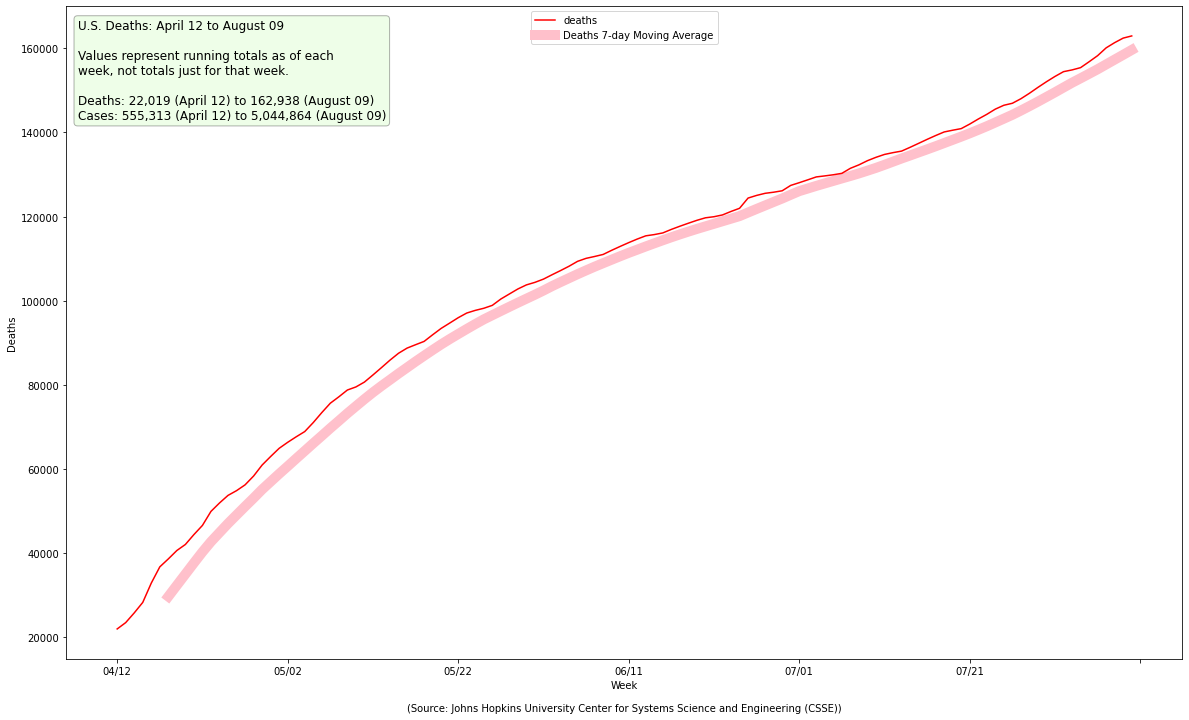

In [9]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3d85550>)

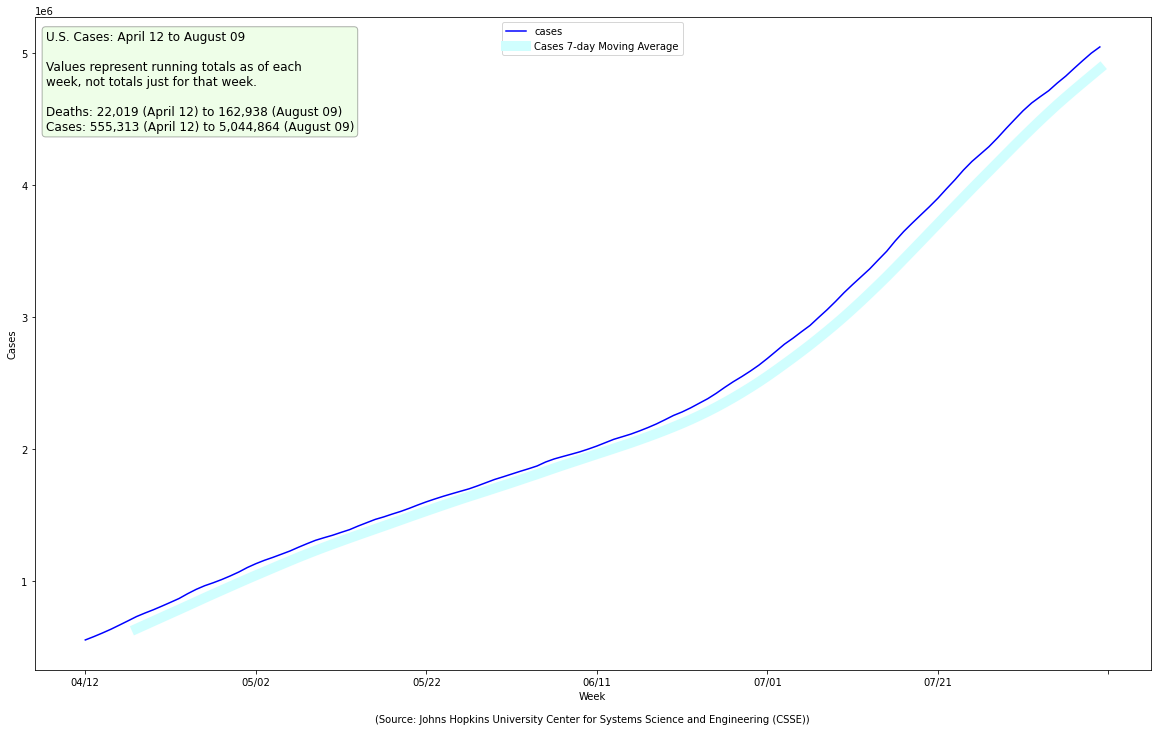

In [10]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

#### Positivity Rate

The positivity rate is problematic. At the beginning of the pandemic,
we weren't testing much at all, and the tests were reserved largely
for those showing symptoms. So the positivity rate was, not surprisingly,
quite high. It will have declined over time, because we're testing more
of the population, including more people who come up negative.

Rather than plot the positivity rate since April, which is somewhat
misleading, just plot the positivity rate for the last 45 days.

**Note**: A drop-off toward the end isn't necessarily cause for celebration.
Reporting of cases probably lags.

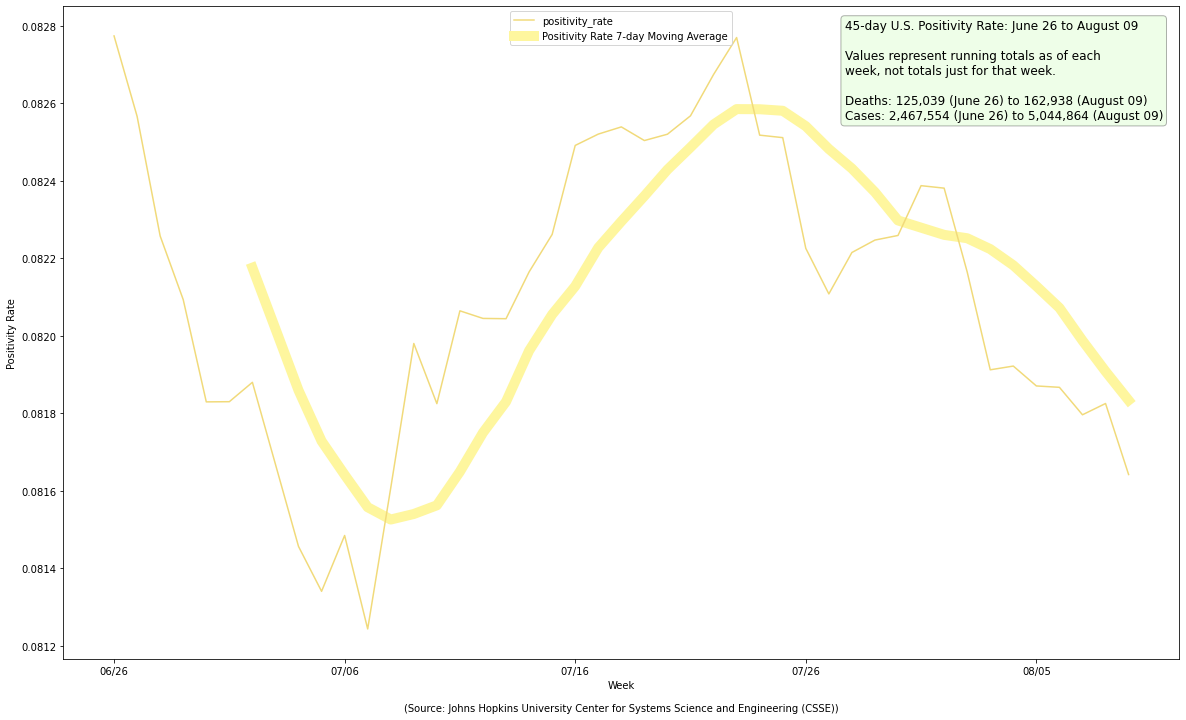

In [11]:
delta = timedelta(days=45)
cutoff = date_to_datetime(today - delta)
df_positivity_dates = df.loc[df.date >= cutoff]
fig, ax = plot_stats_by_date(df_positivity_dates, SOURCE, metrics={MetricType.POSITIVITY},
                             image_file='jhu-us-positivity-rate.png', 
                             textbox_heading="45-day U.S. Positivity Rate",
                             textbox_loc=(0.7, 0.98),
                             moving_average=True)

#### Daily values, instead of cumulative values

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3cd51f0>)

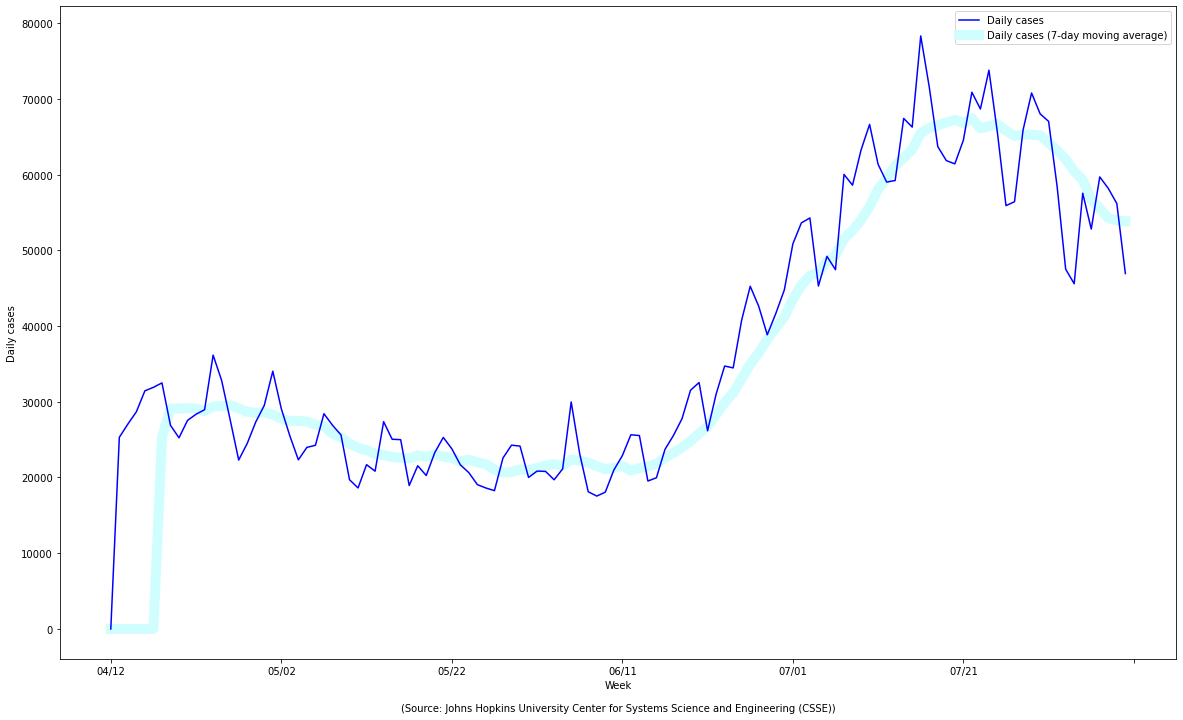

In [12]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3bacdf0>)

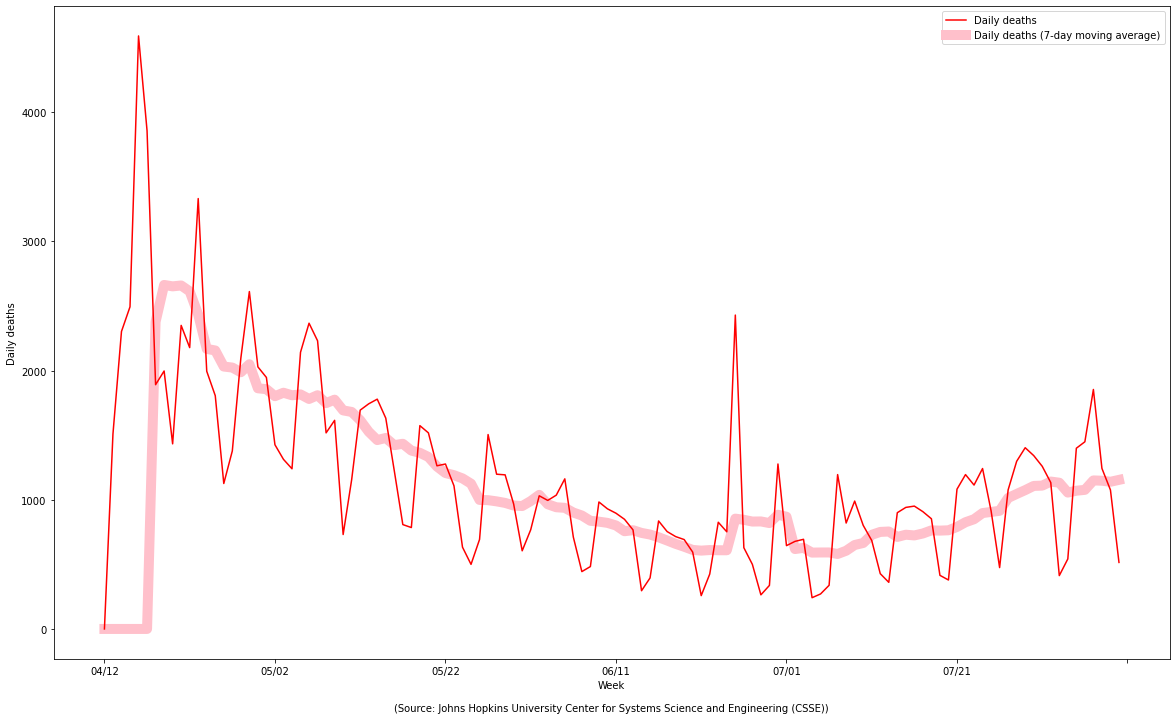

In [13]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-deaths-daily.png")

#### Just the past week

In [14]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3b14850>)

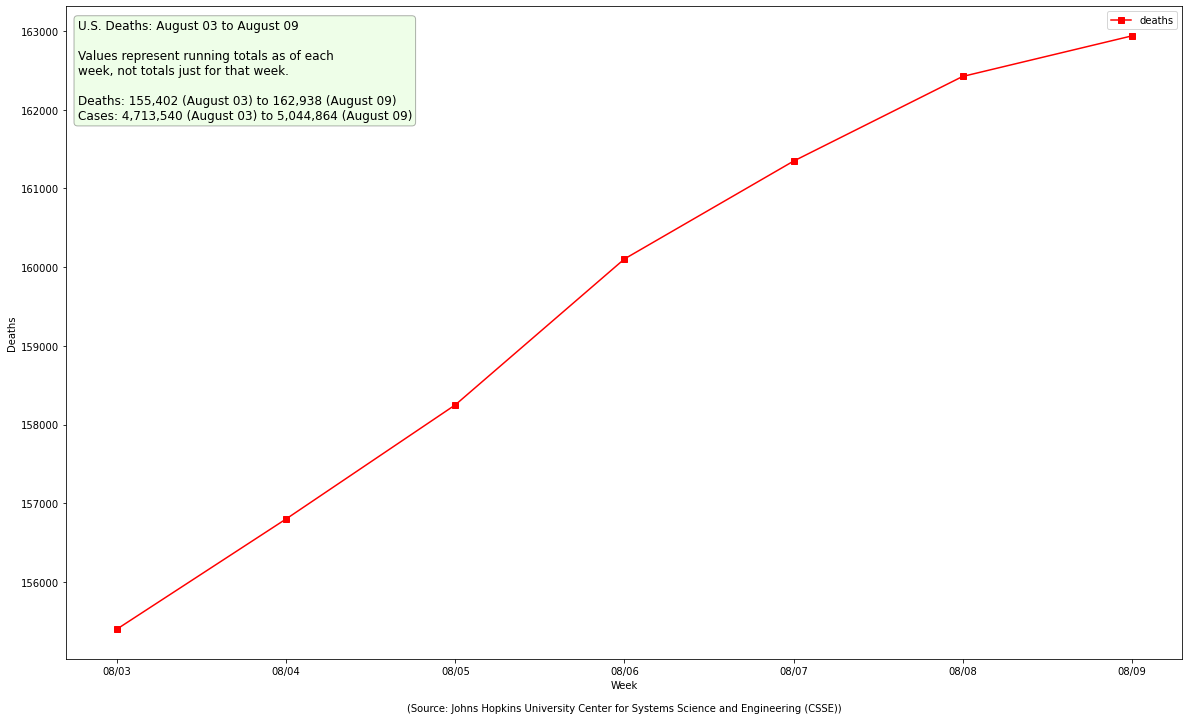

In [15]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

#### Deaths vs. Cases

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3ad6580>)

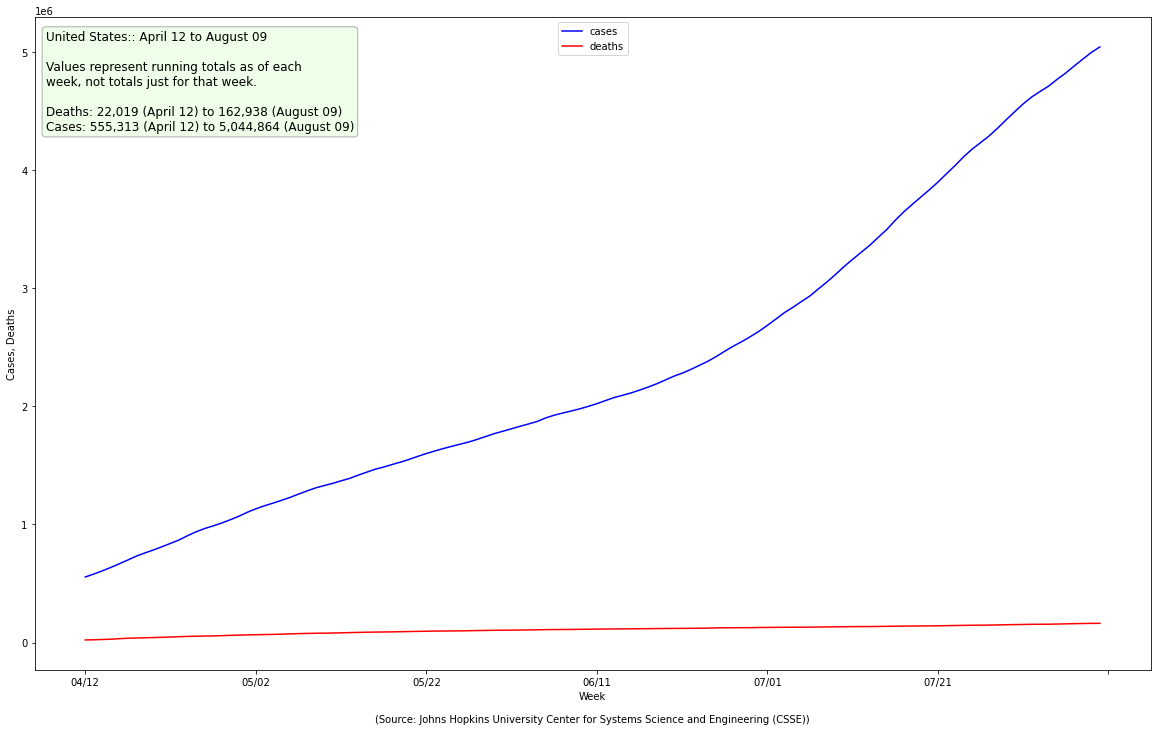

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3b0b4f0>)

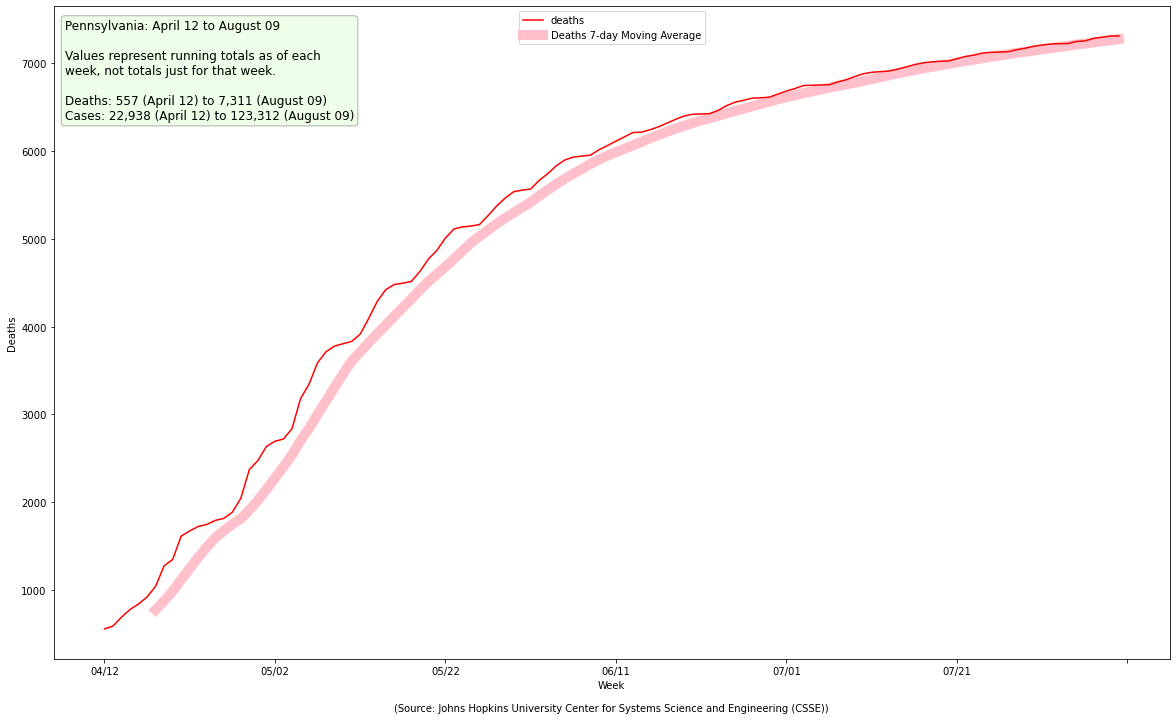

In [17]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3ac3a90>)

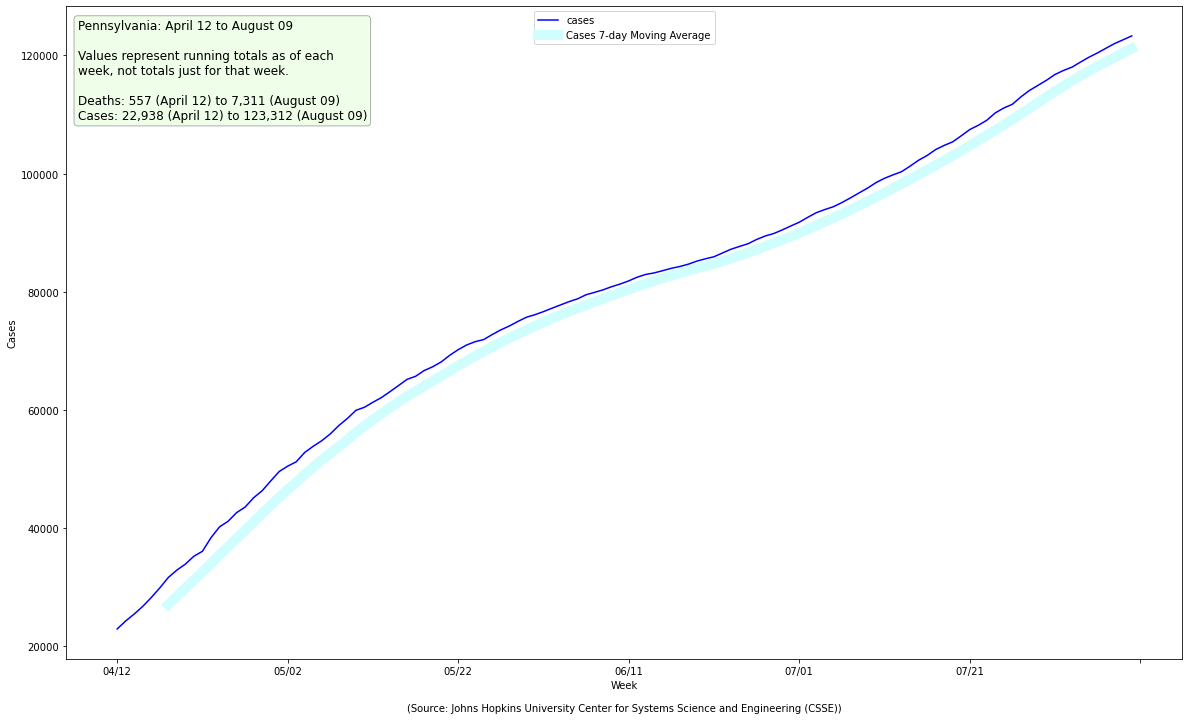

In [18]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3997460>)

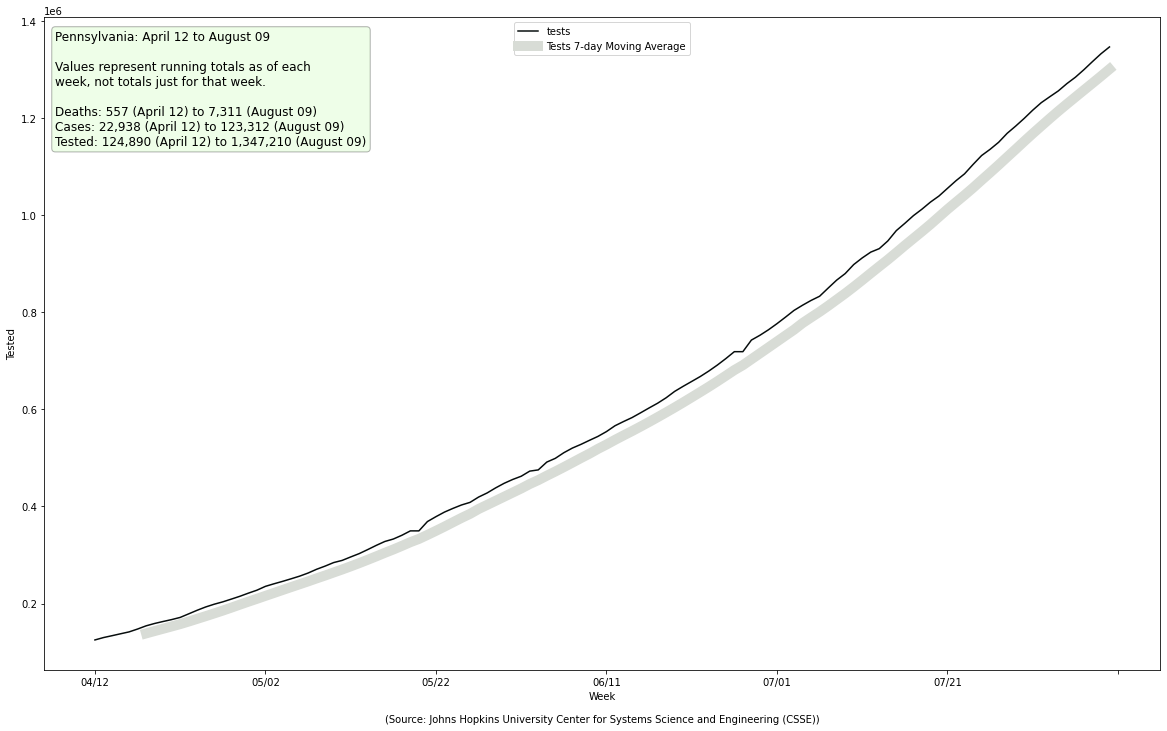

In [19]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf39802b0>)

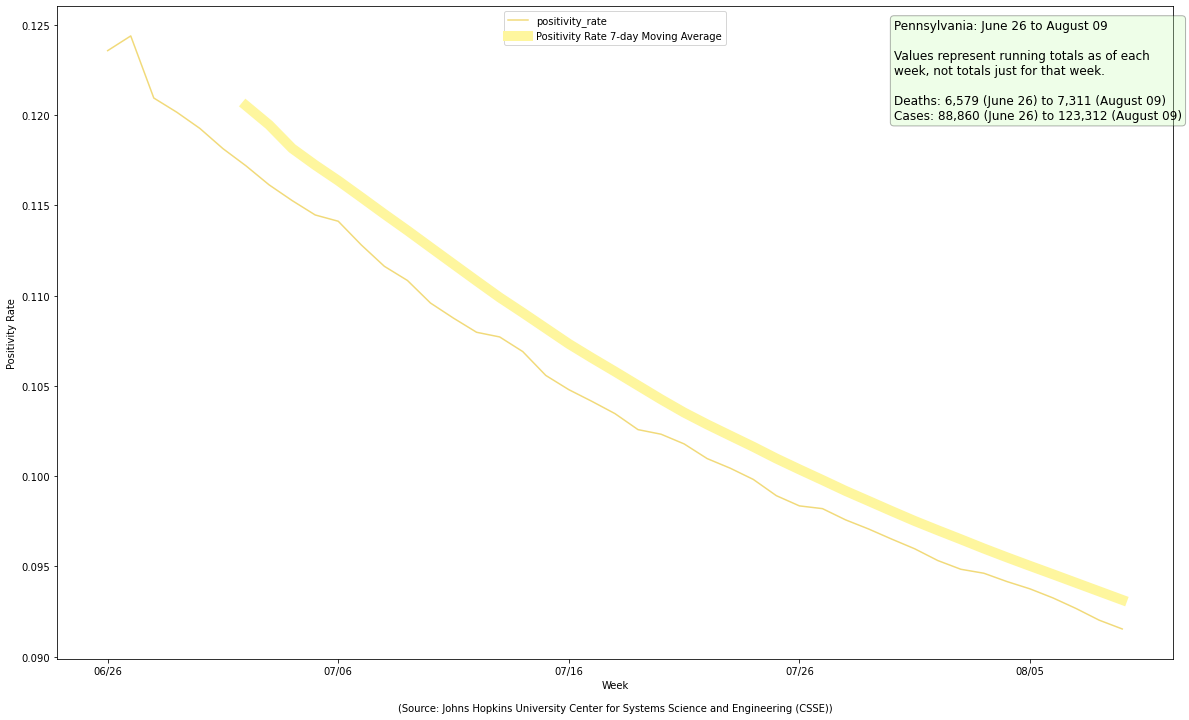

In [20]:
# Note caveats on positivity rate in the U.S. section, above.
plot_state(df_positivity_dates, SOURCE, 'Pennsylvania', metrics={MetricType.POSITIVITY},
           image_file='jhu-pa-positivity.png', moving_average=True, textbox_loc=(0.75, 0.98))

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf38f2580>)

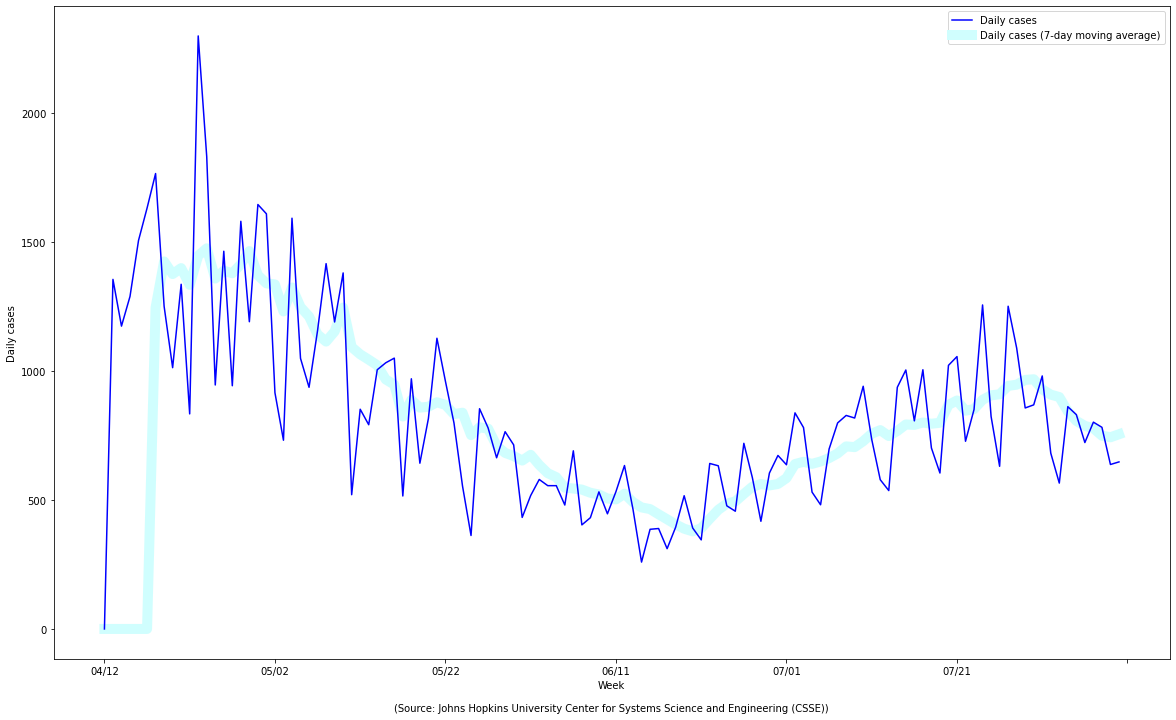

In [21]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf38e3b80>)

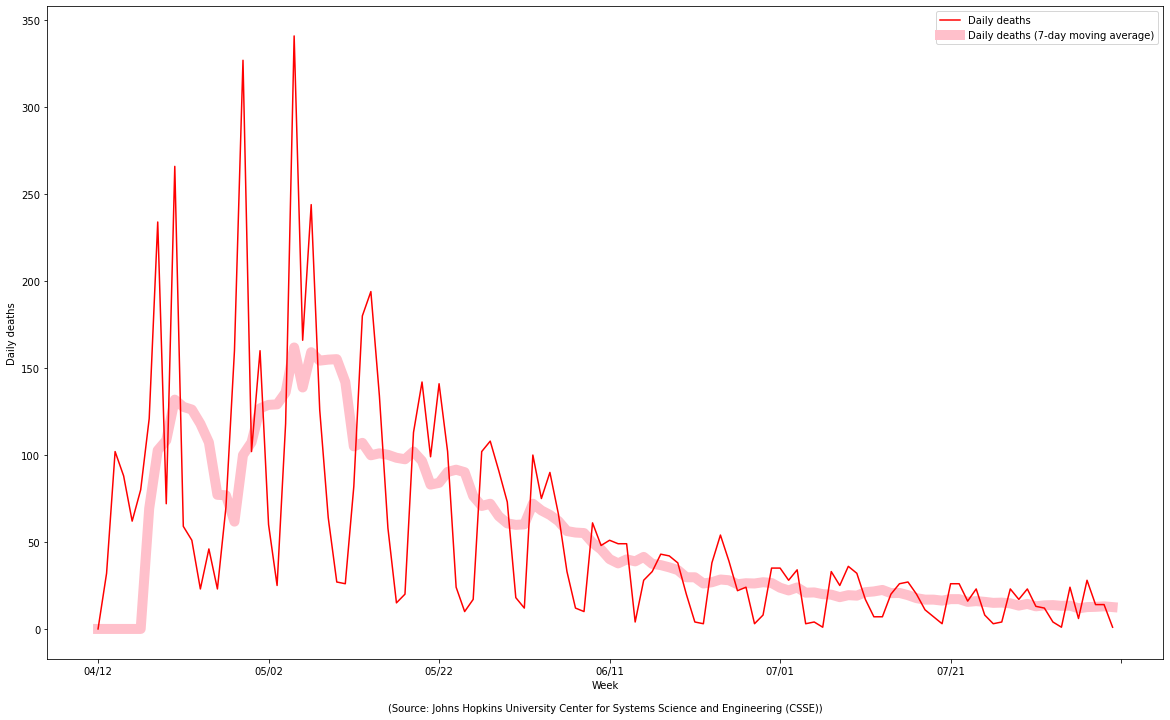

In [22]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png")

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf04af0a0>)

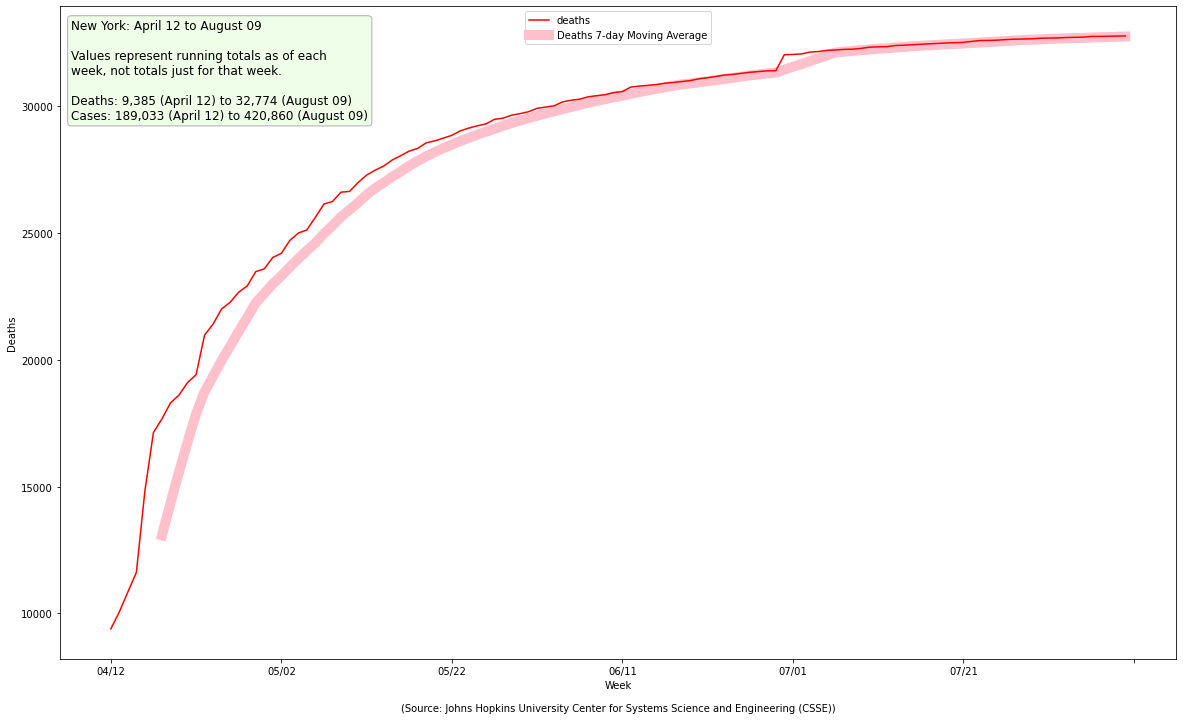

In [23]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf0436b80>)

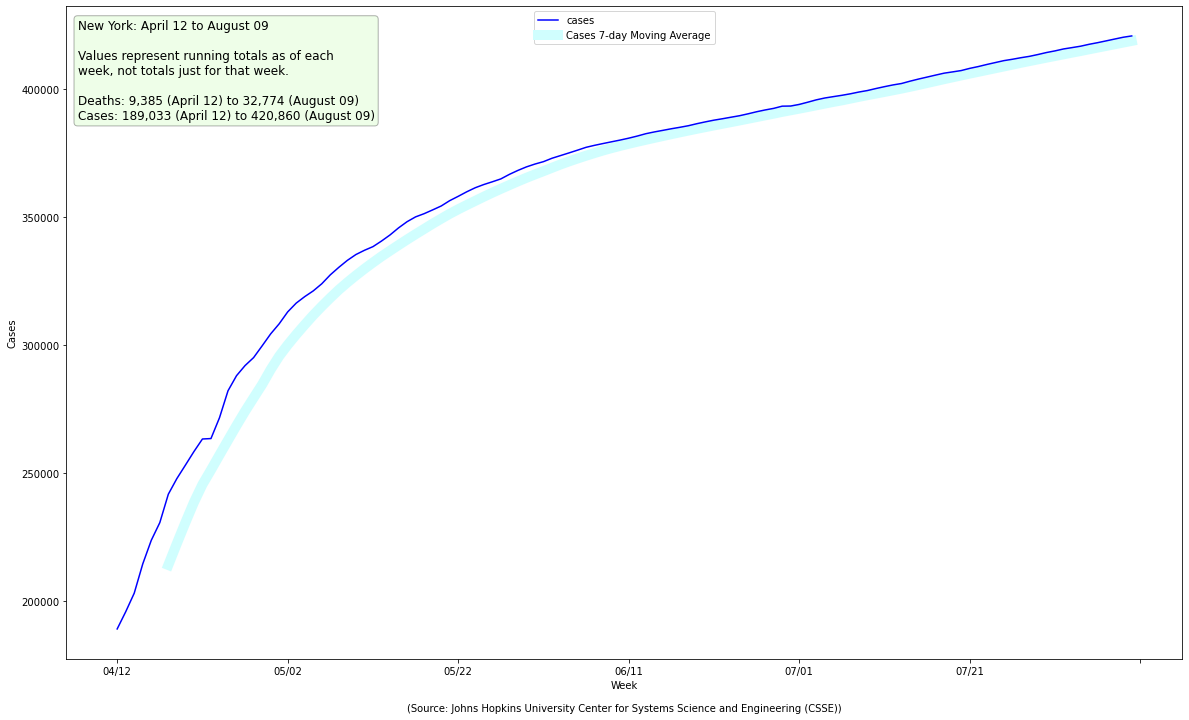

In [24]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf03b2880>)

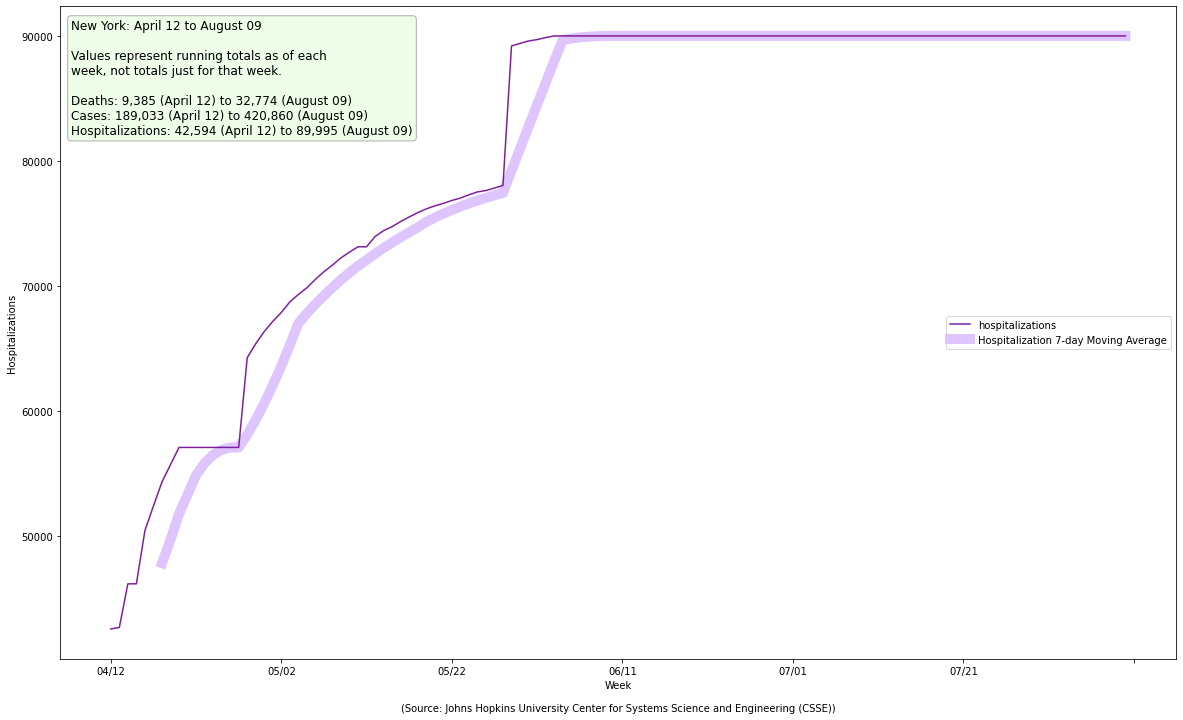

In [25]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, 
           moving_average=True, legend_loc='center right')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf03759d0>)

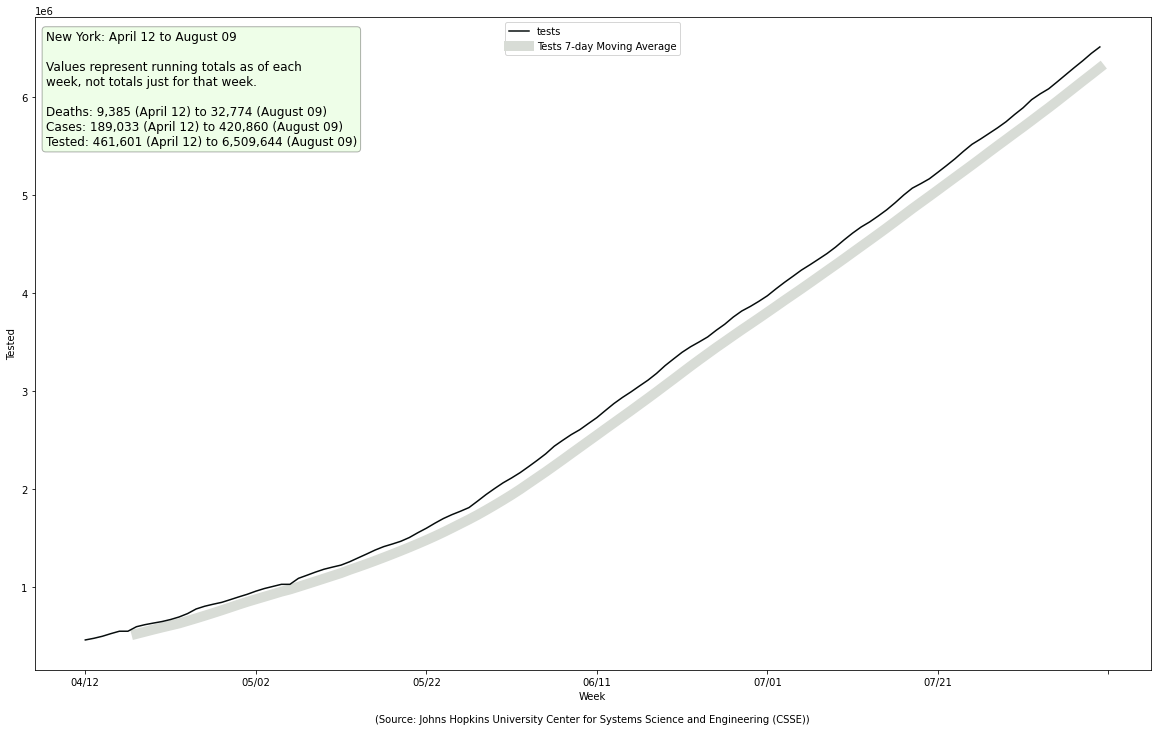

In [26]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf3b681f0>)

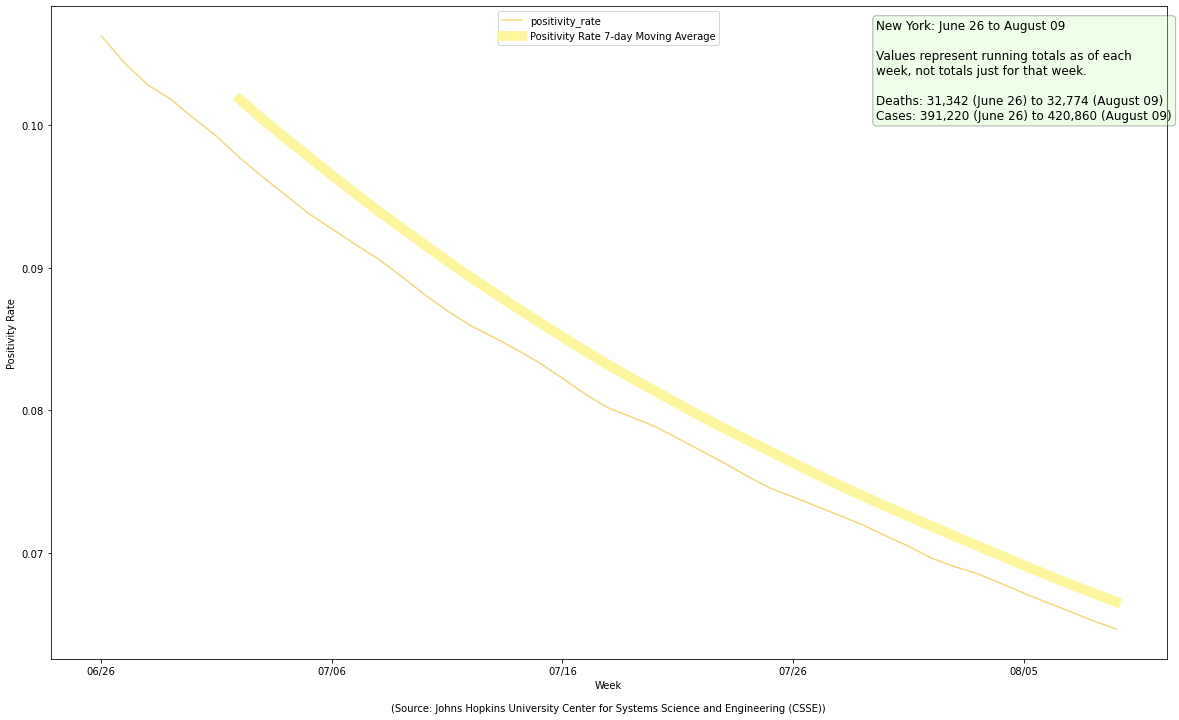

In [27]:
plot_state(df_positivity_dates, SOURCE, 'New York', image_file='jhu-ny-pos.png', 
           metrics={MetricType.POSITIVITY}, textbox_loc=(0.74, 0.98), moving_average=True)

#### California

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf04e9850>)

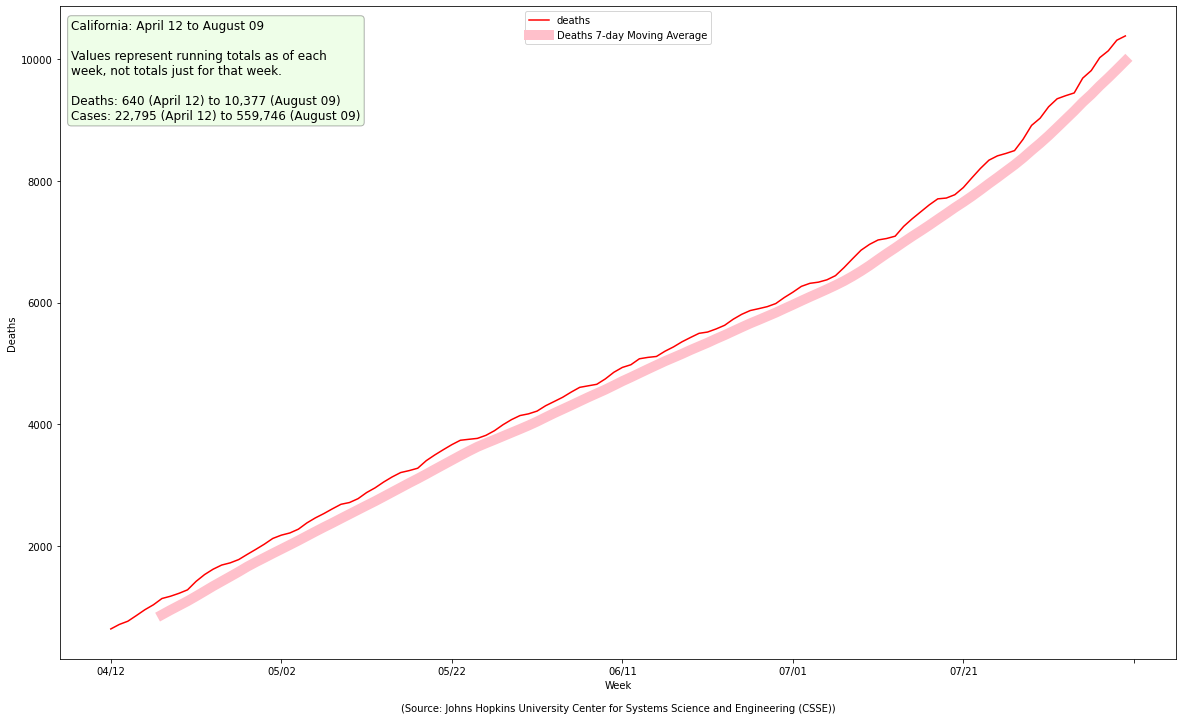

In [28]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf0268f10>)

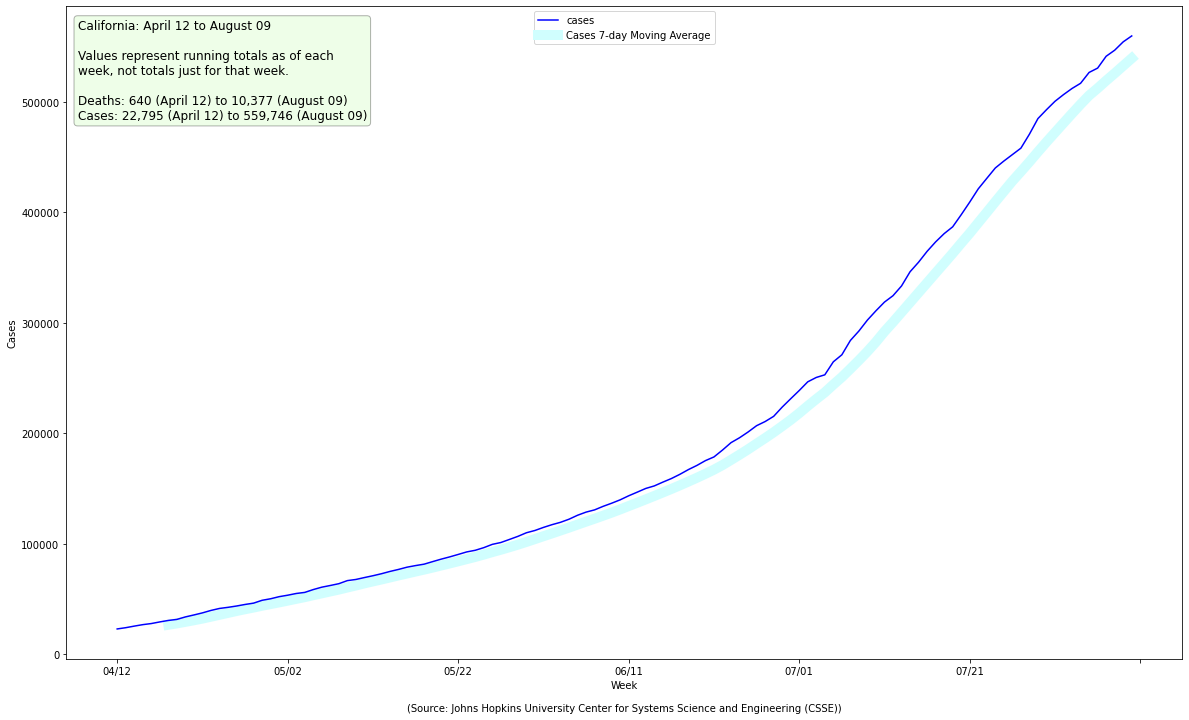

In [29]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf018b340>)

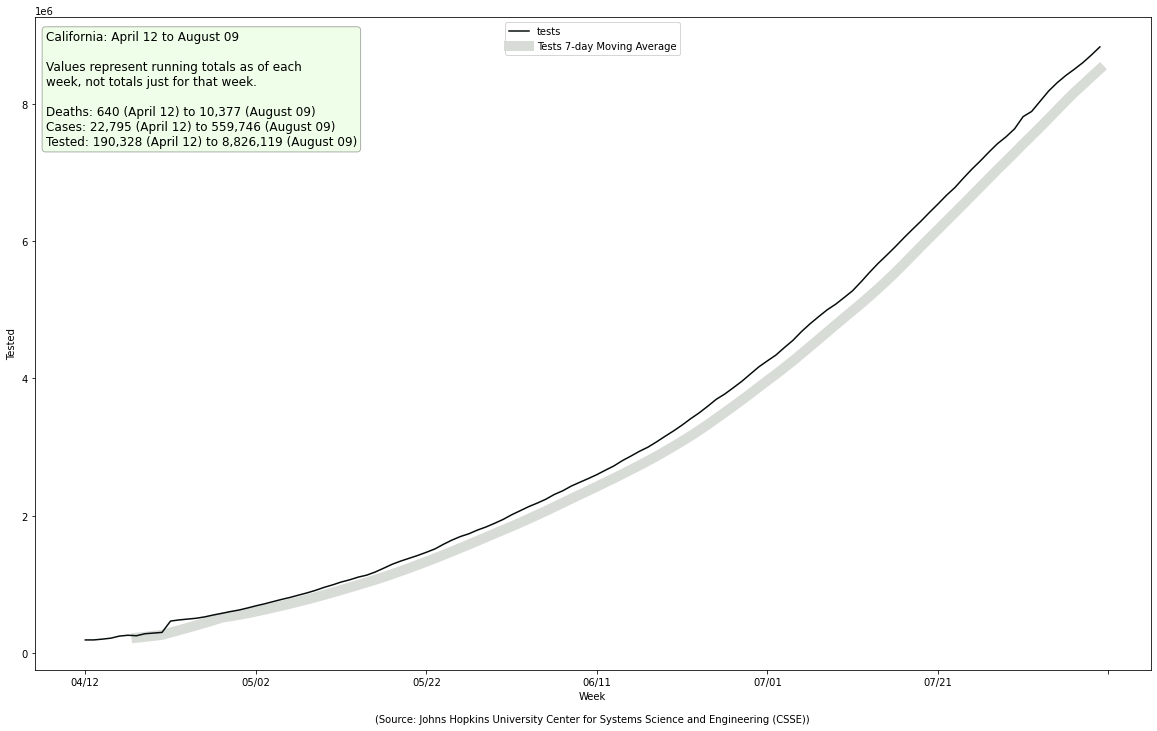

In [30]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-tests.png', 
           metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf01b8d60>)

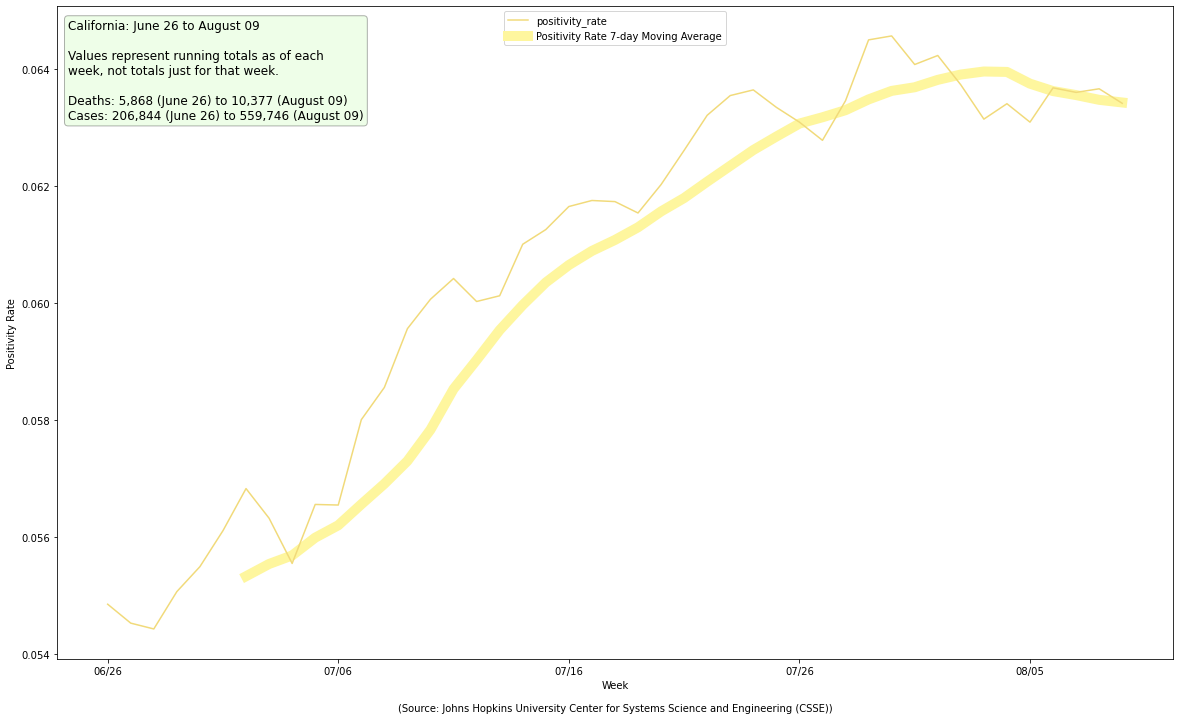

In [31]:
plot_state(df_positivity_dates, SOURCE, 'California', image_file='jhu-ca-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf012aeb0>)

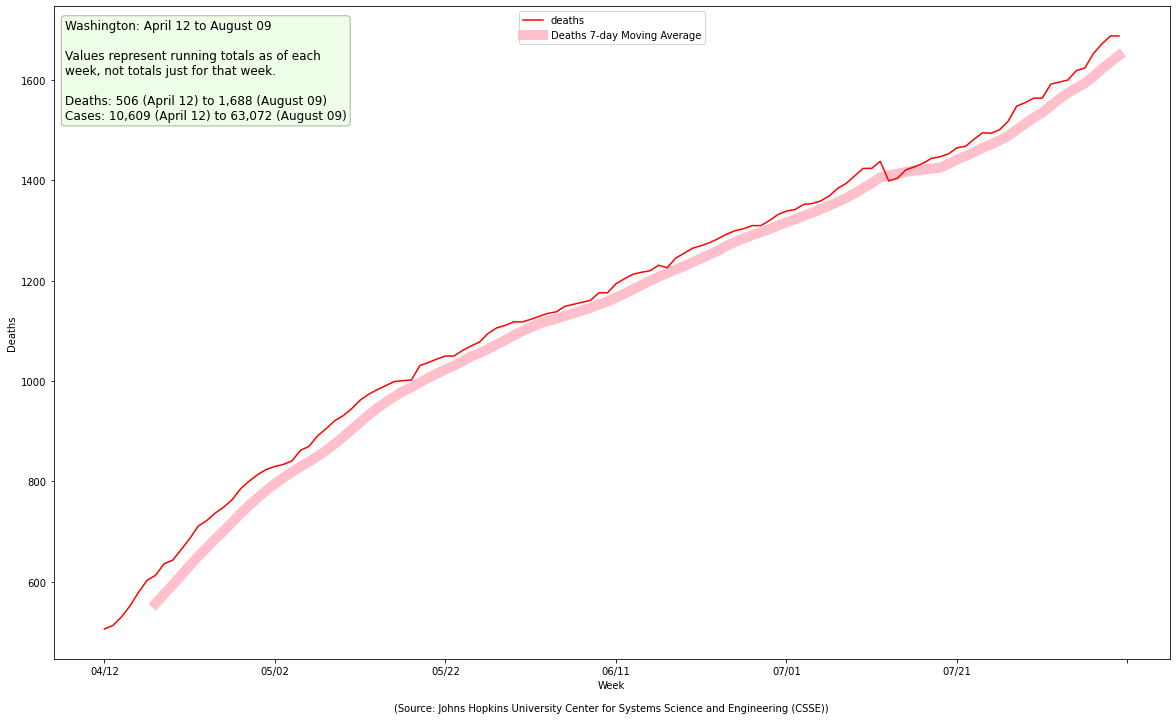

In [32]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf00ba520>)

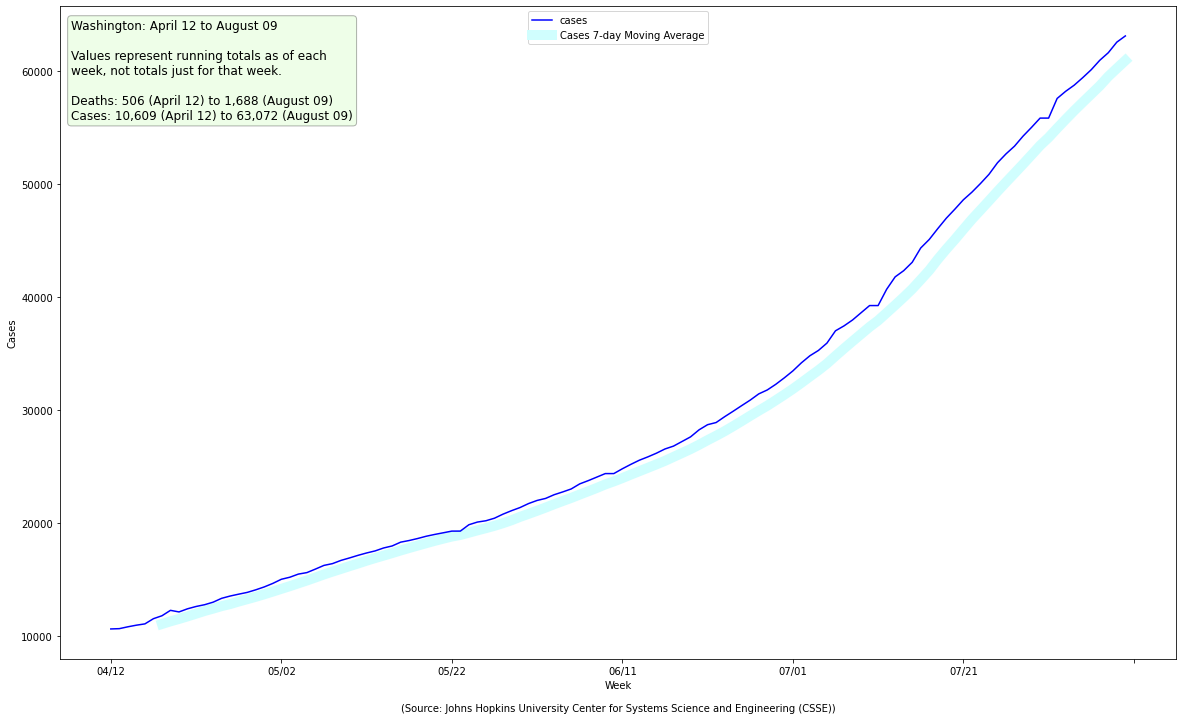

In [33]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf00231f0>)

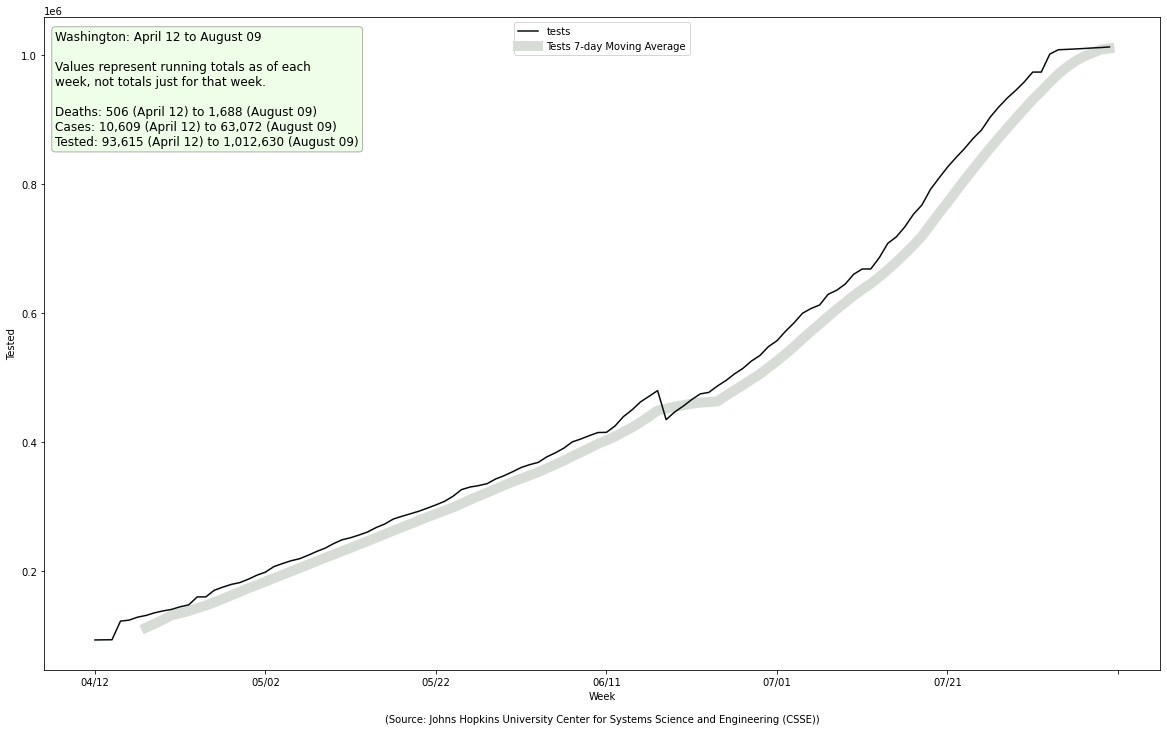

In [34]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea77d6a0>)

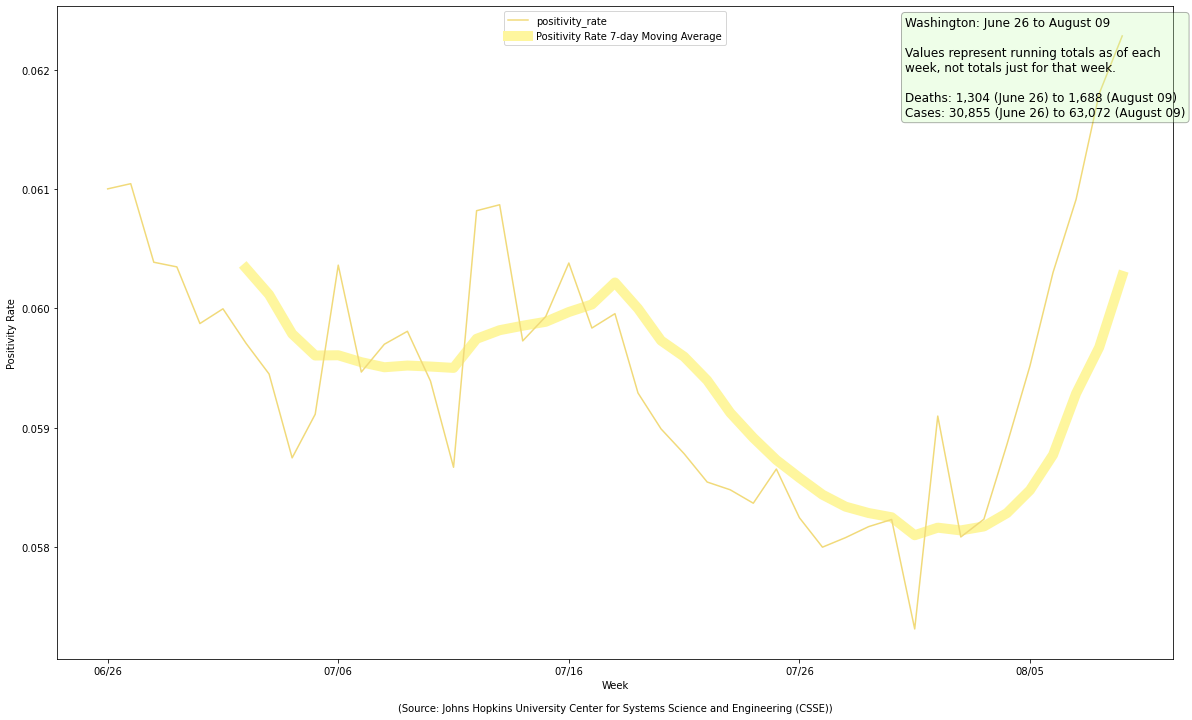

In [35]:
plot_state(df_positivity_dates, SOURCE, 'Washington', image_file='jhu-wa-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True, textbox_loc=(0.76, 0.985))

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea74c310>)

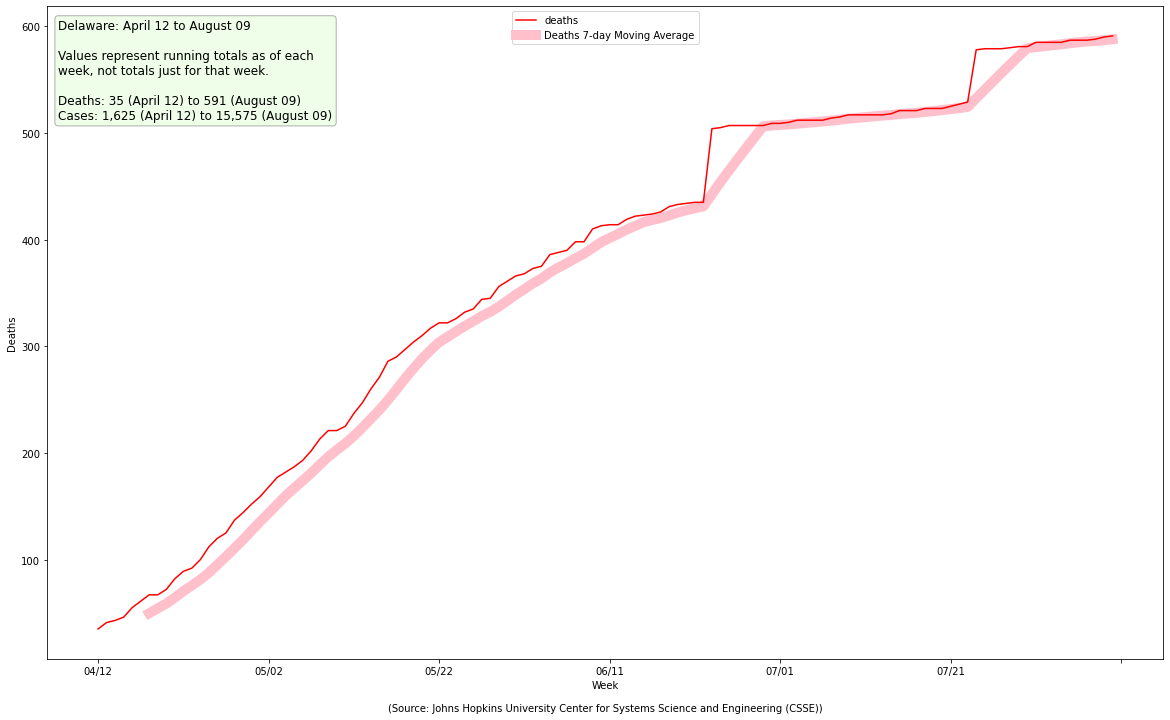

In [36]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea6c06d0>)

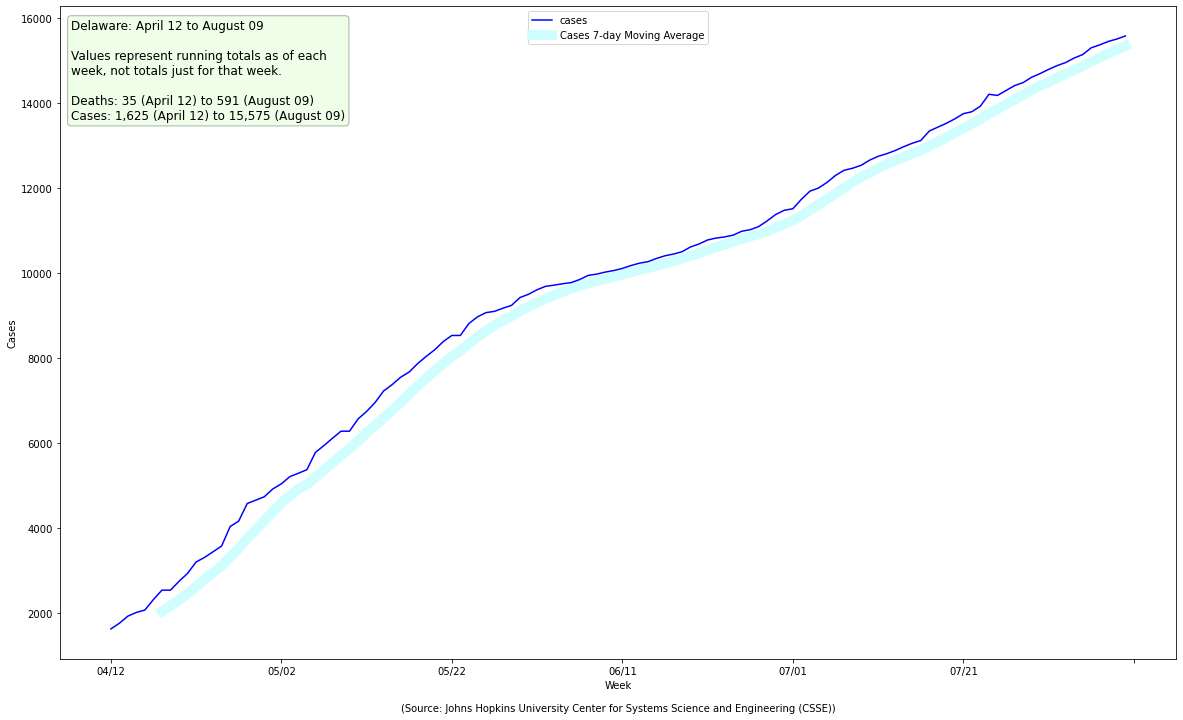

In [37]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea6b7430>)

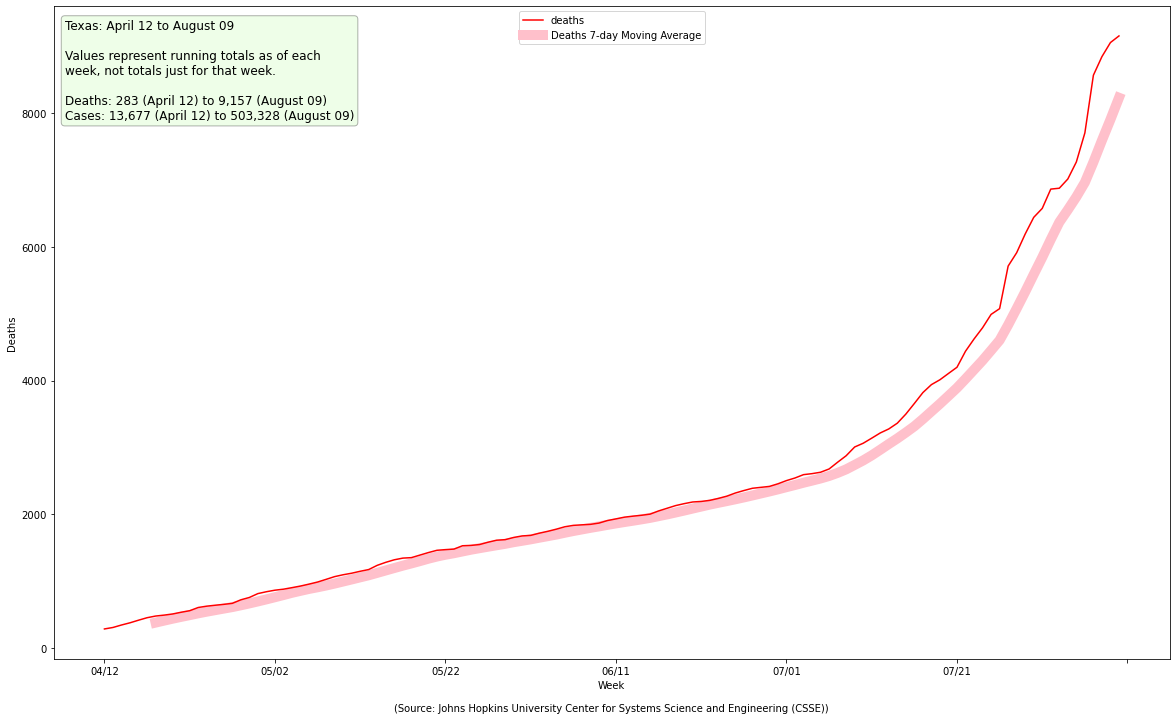

In [38]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea65f100>)

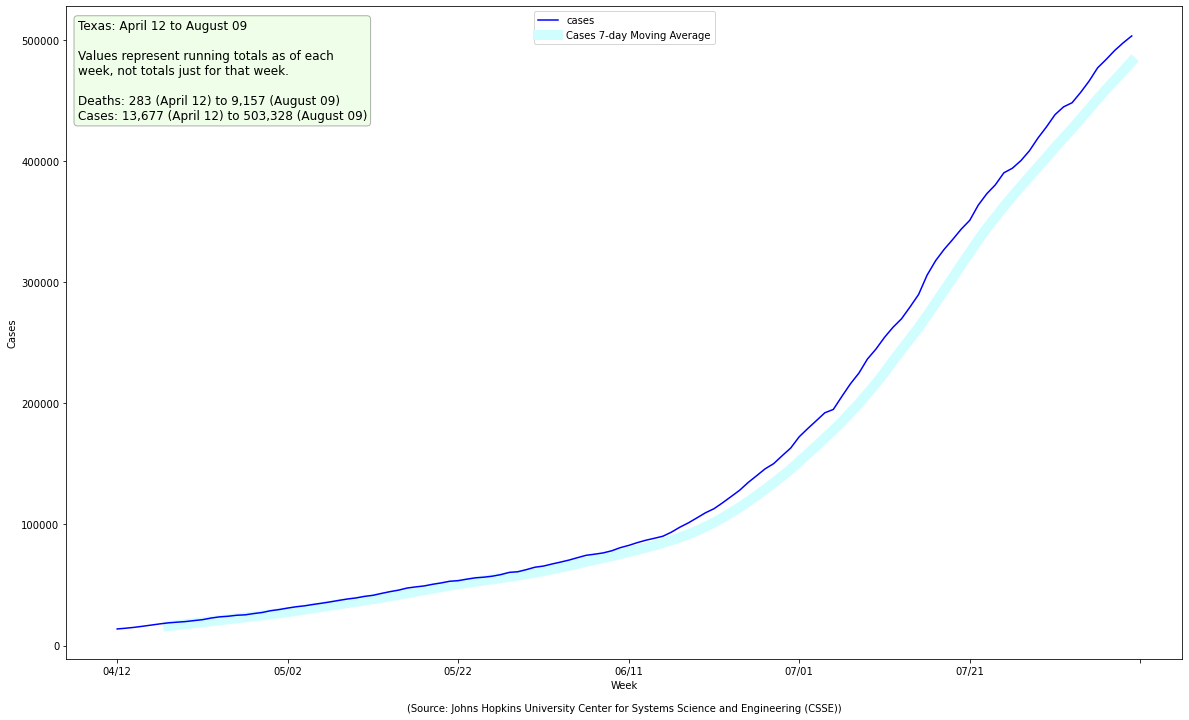

In [39]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf01672e0>)

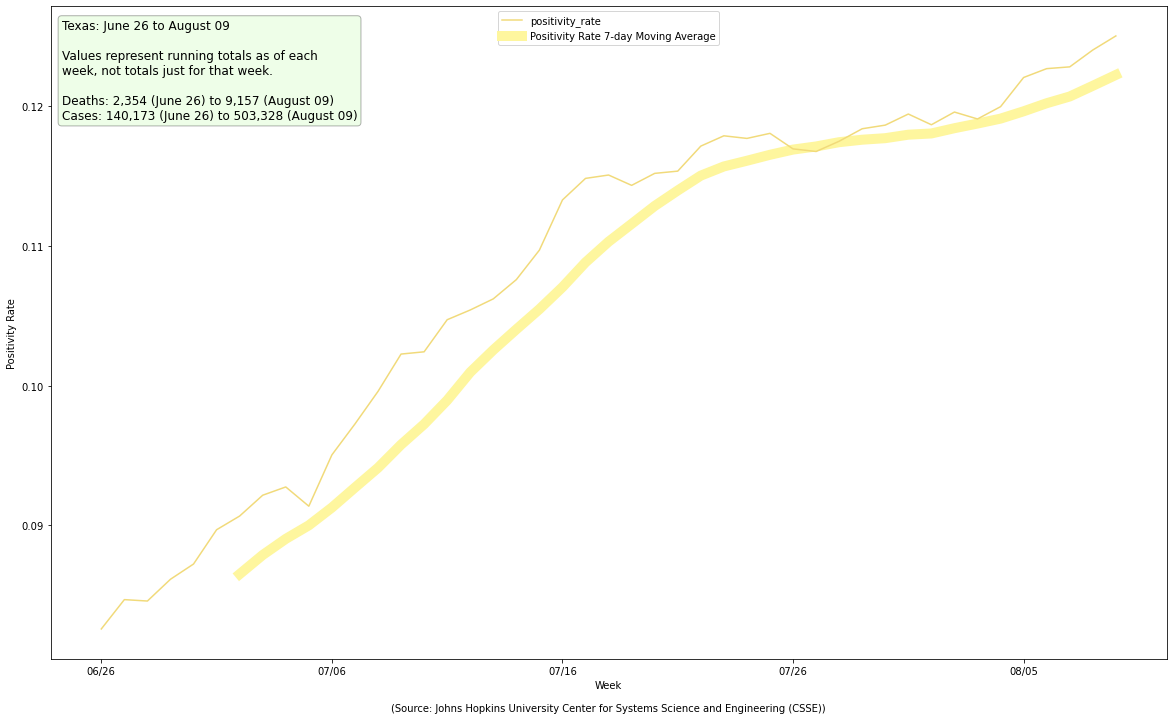

In [40]:
plot_state(df_positivity_dates, SOURCE, 'Texas', image_file='jhu-tx-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf00b2b50>)

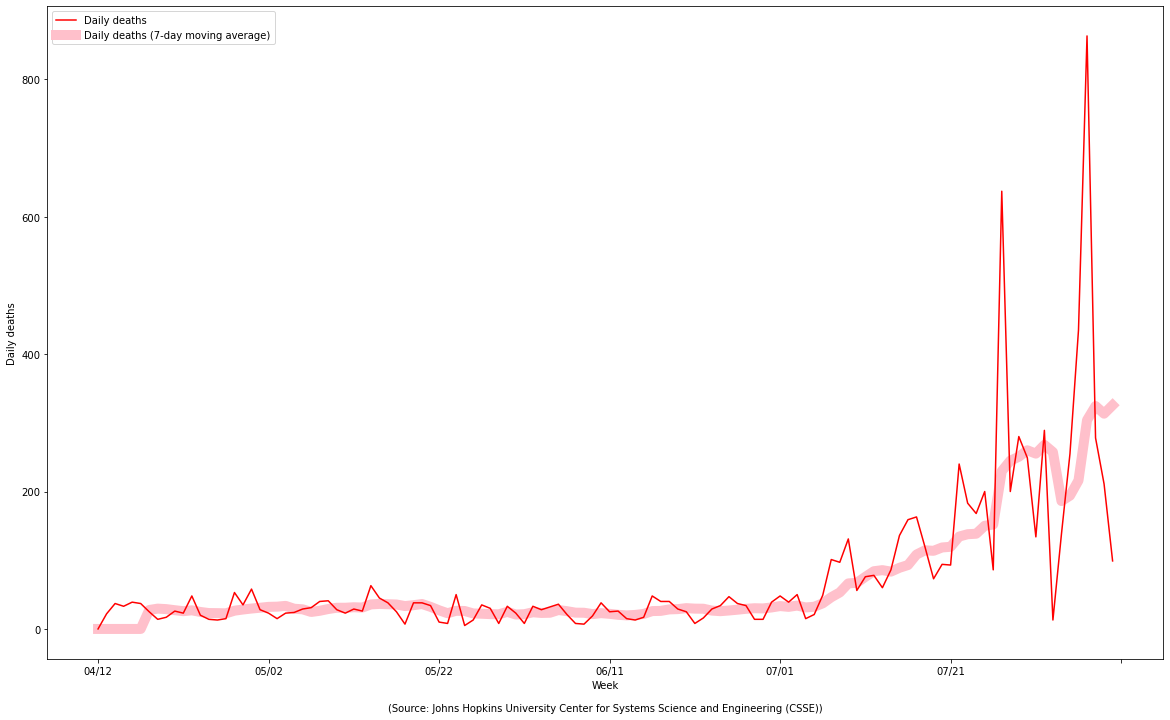

In [41]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png")

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea5490d0>)

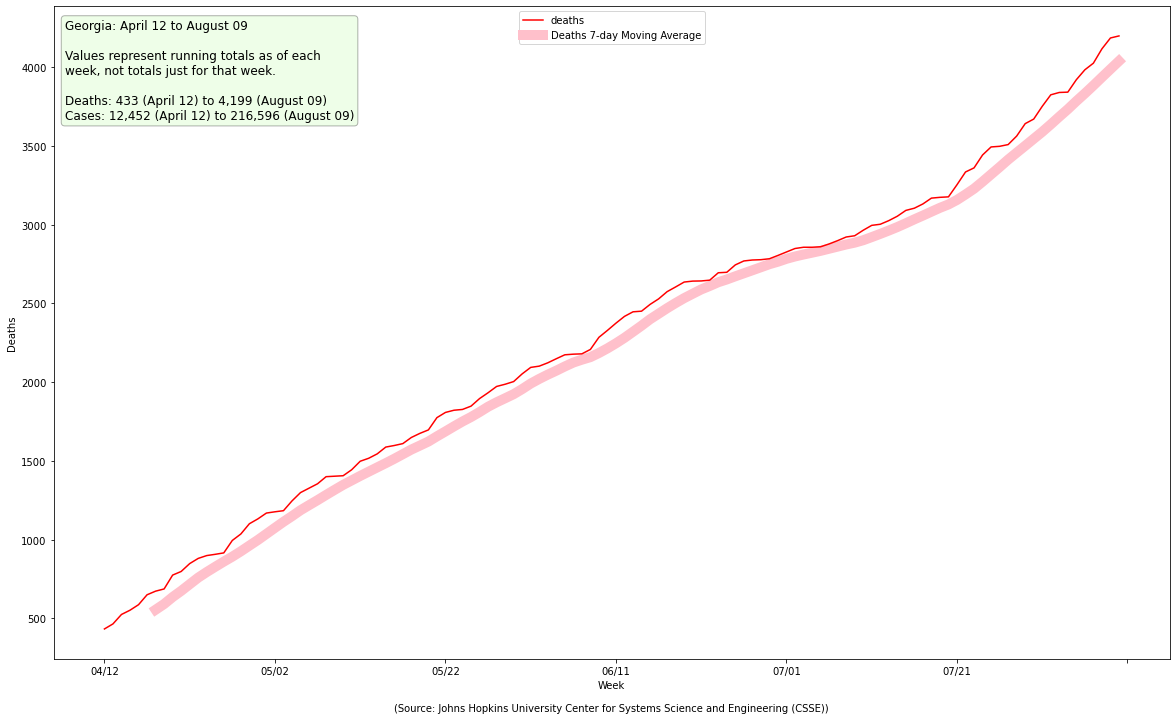

In [42]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea4e8ac0>)

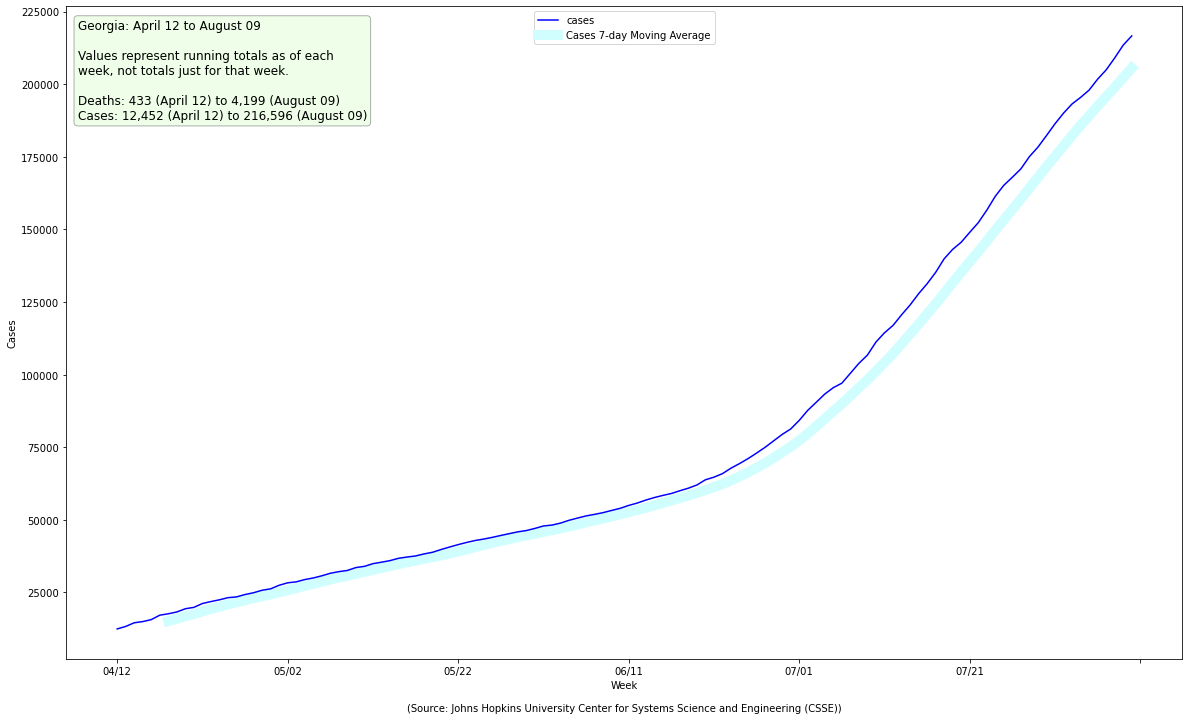

In [43]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea4936a0>)

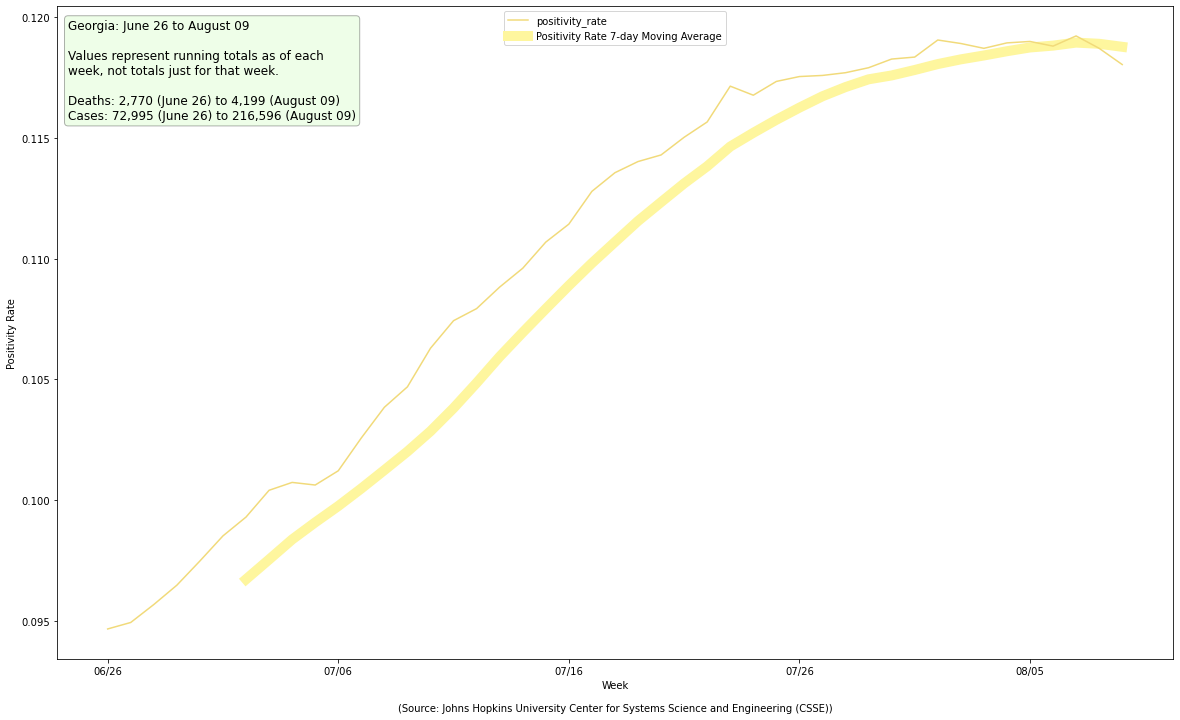

In [44]:
plot_state(df_positivity_dates, SOURCE, 'Georgia', image_file='jhu-ga-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea417be0>)

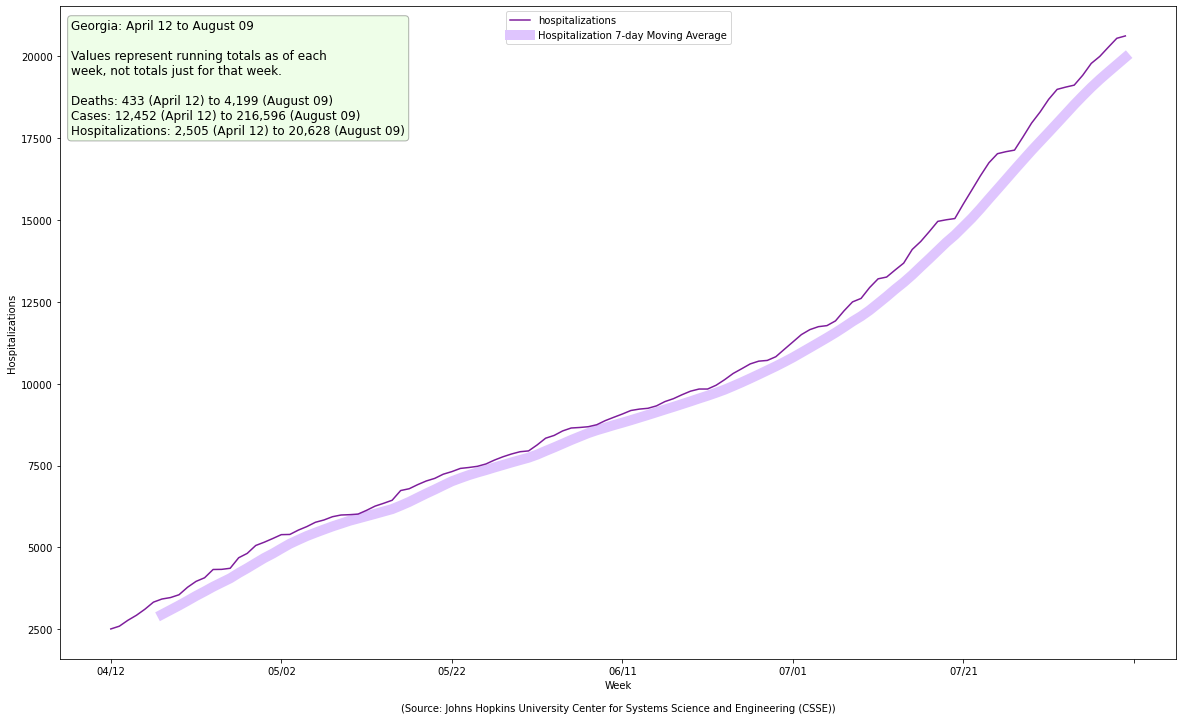

In [45]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea3b35b0>)

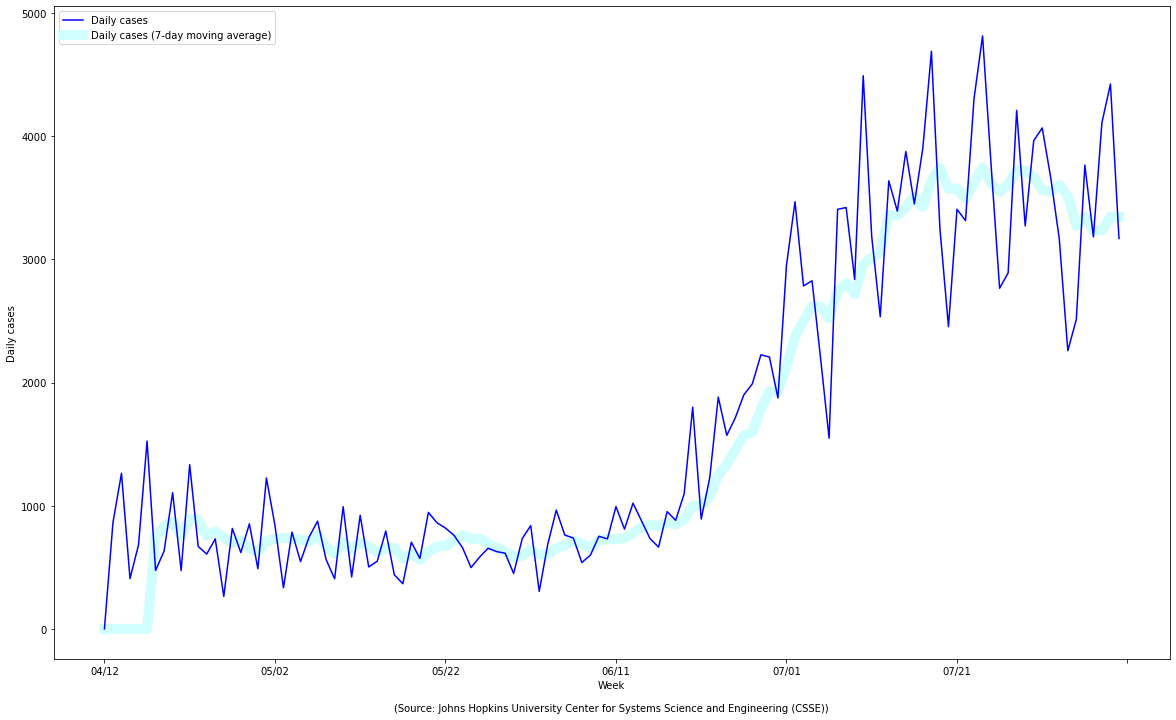

In [46]:
plot_daily_stats(df, SOURCE, region='Georgia', metric=MetricType.CASES, moving_average=True, image_file="jhu-ga-daily-cases.png")

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea314940>)

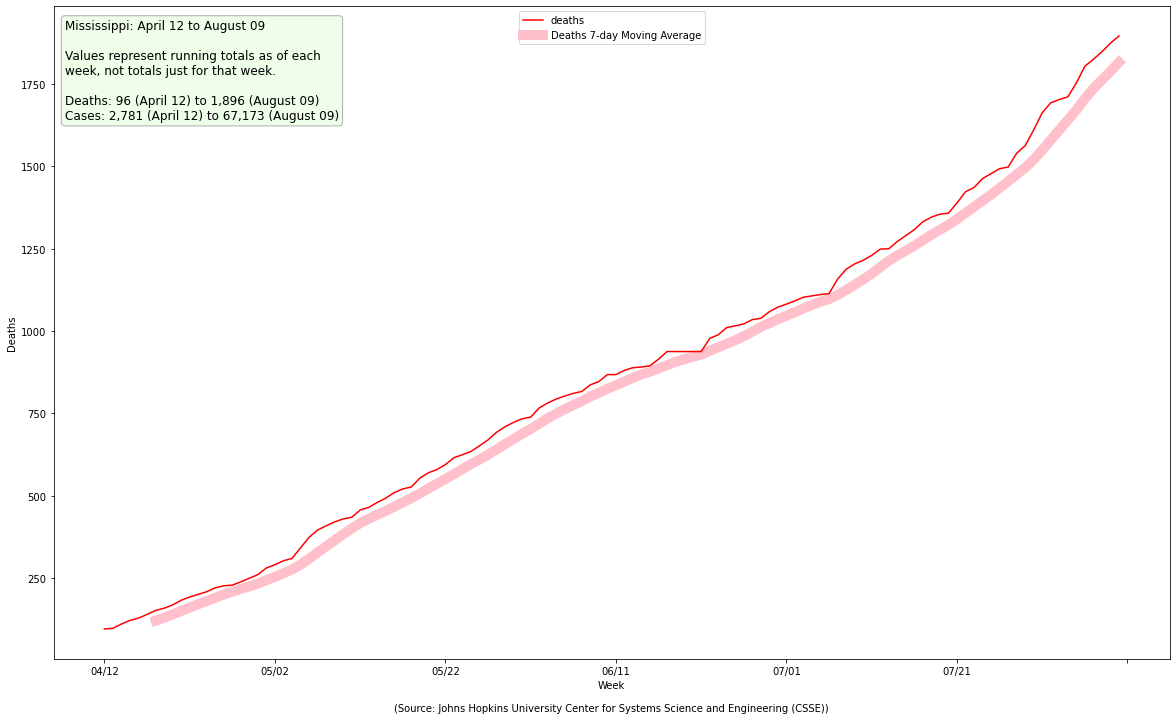

In [47]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea33ae50>)

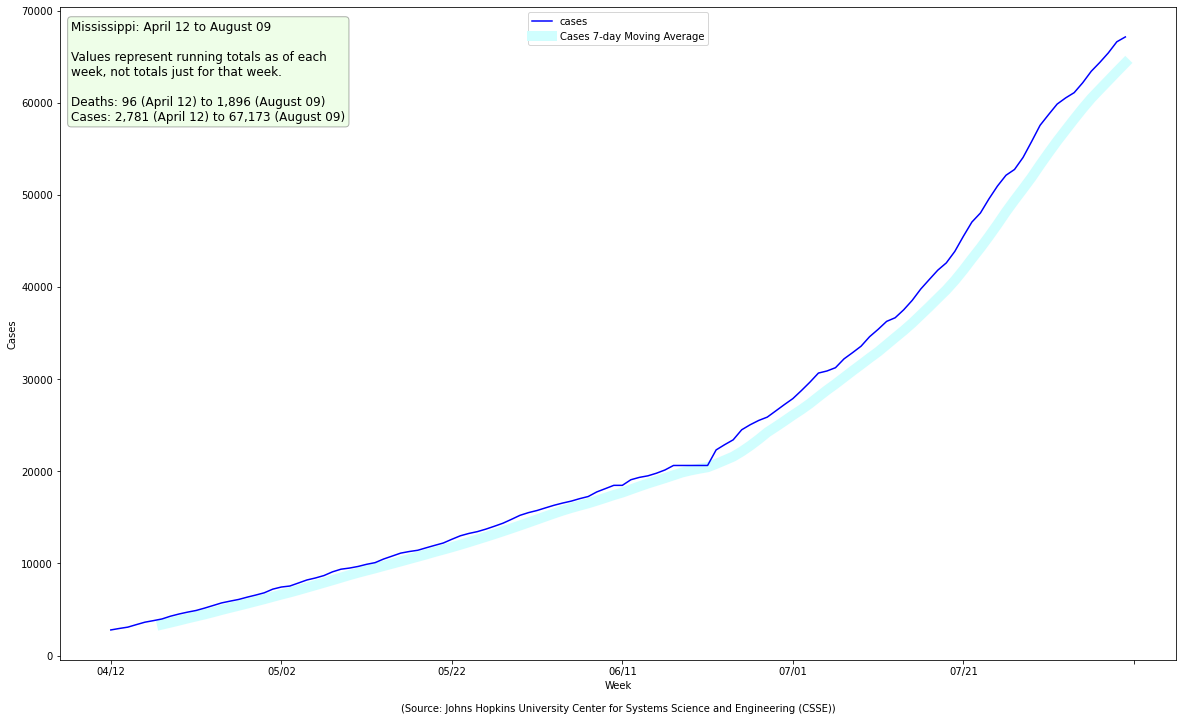

In [48]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea26ee20>)

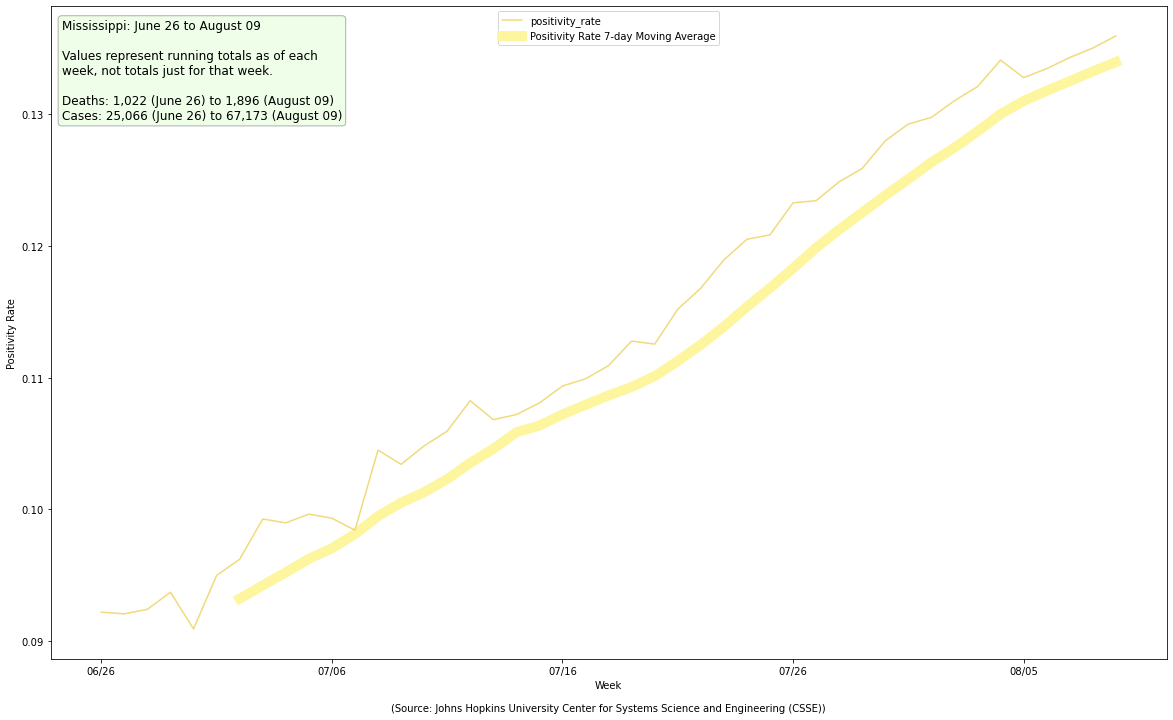

In [49]:
plot_state(df_positivity_dates, SOURCE, 'Mississippi', image_file='jhu-ms-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea1c9eb0>)

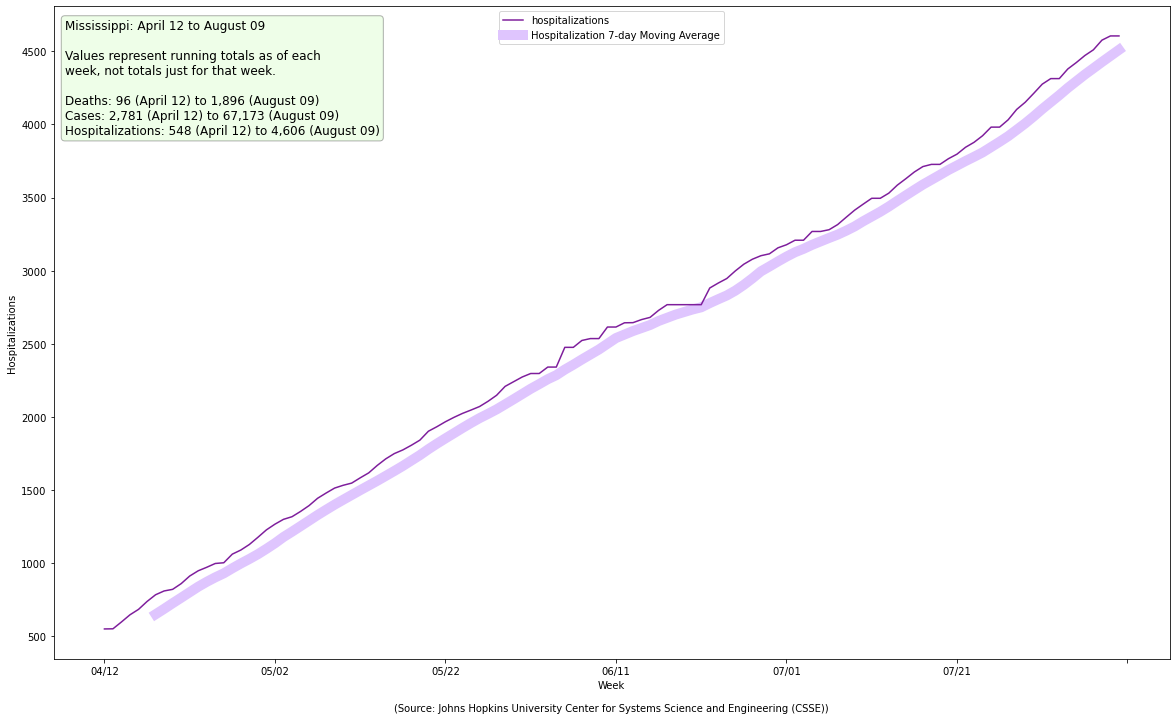

In [50]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea1ce760>)

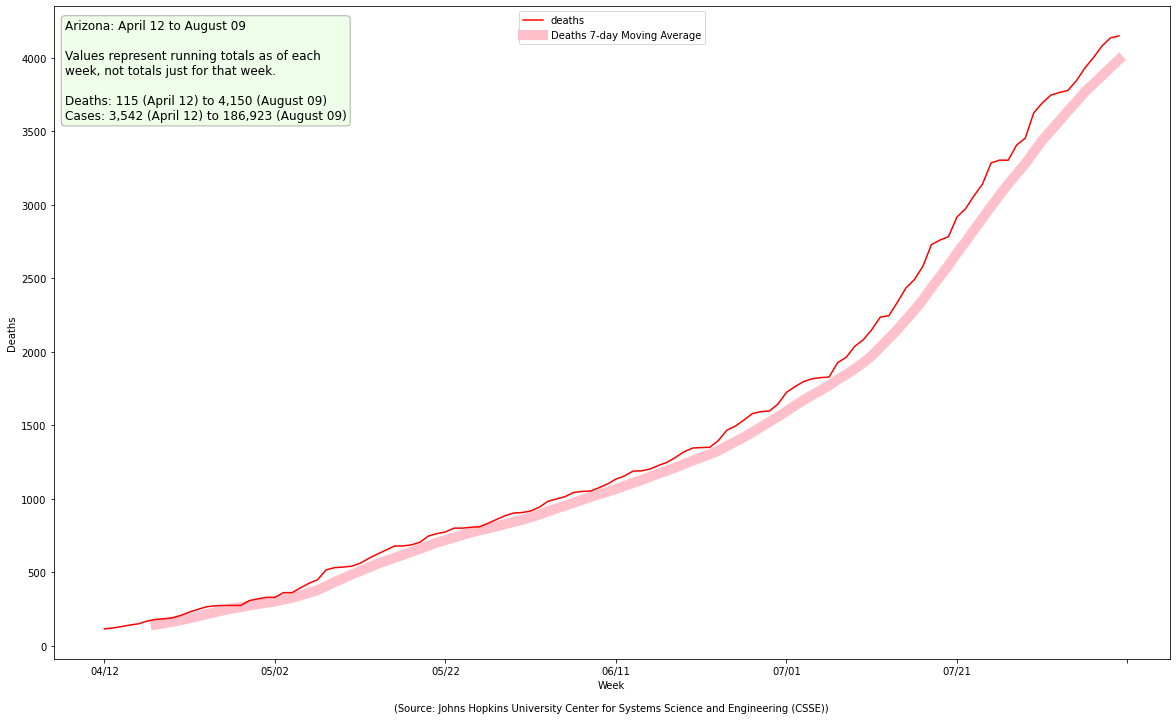

In [51]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea12a550>)

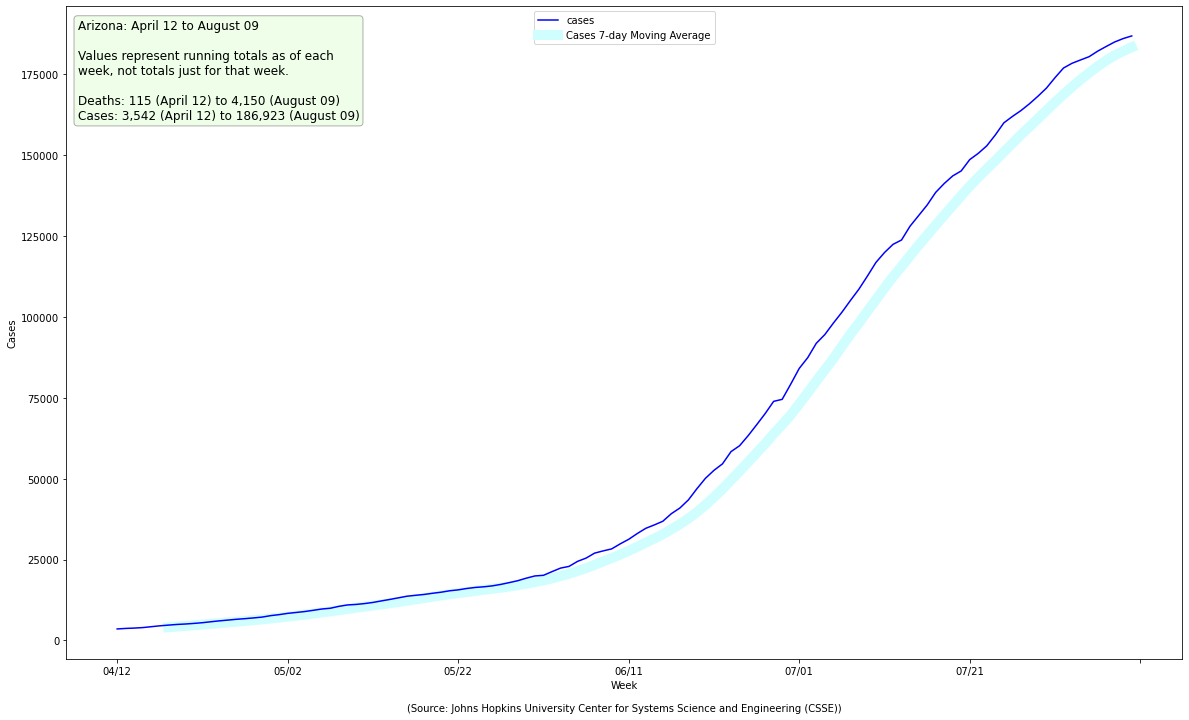

In [52]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea087190>)

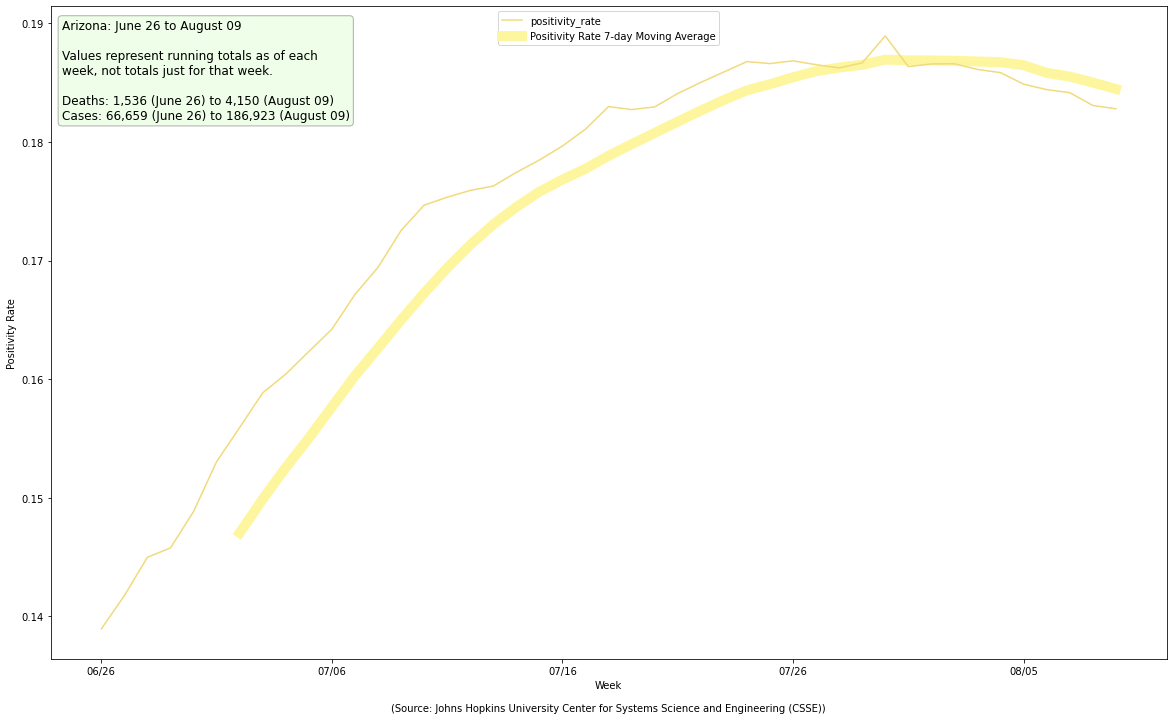

In [53]:
plot_state(df_positivity_dates, SOURCE, 'Arizona', image_file='jhu-az-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cea087dc0>)

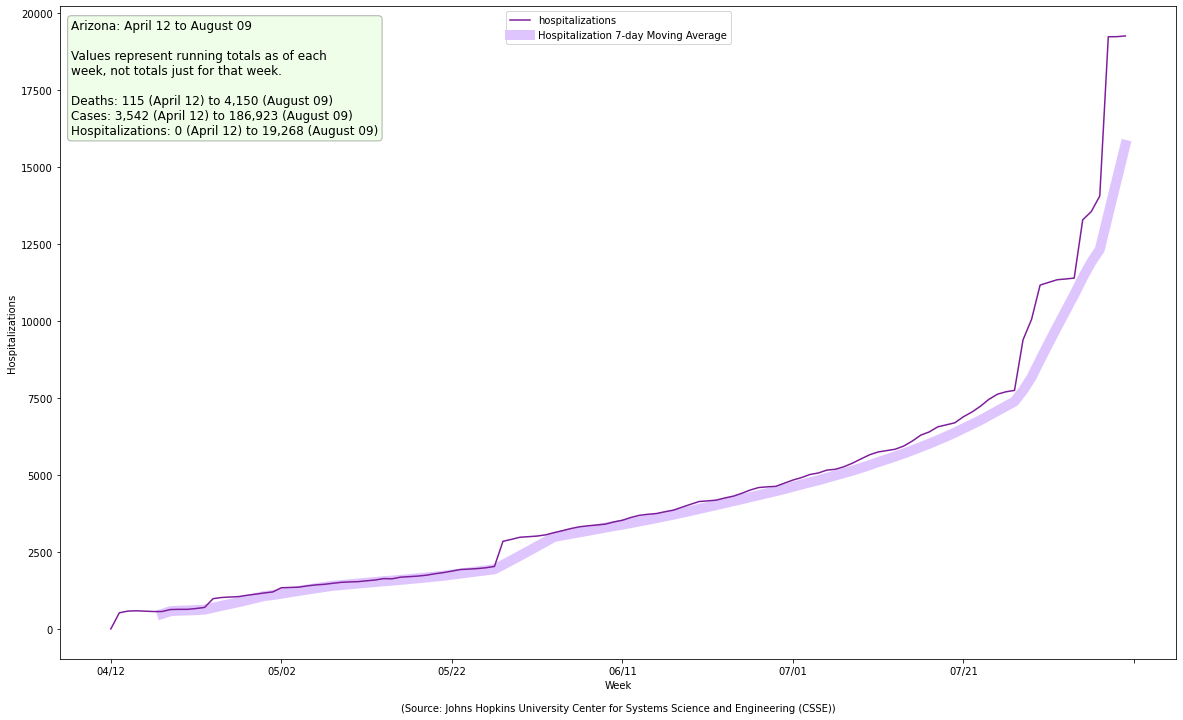

In [54]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf0118520>)

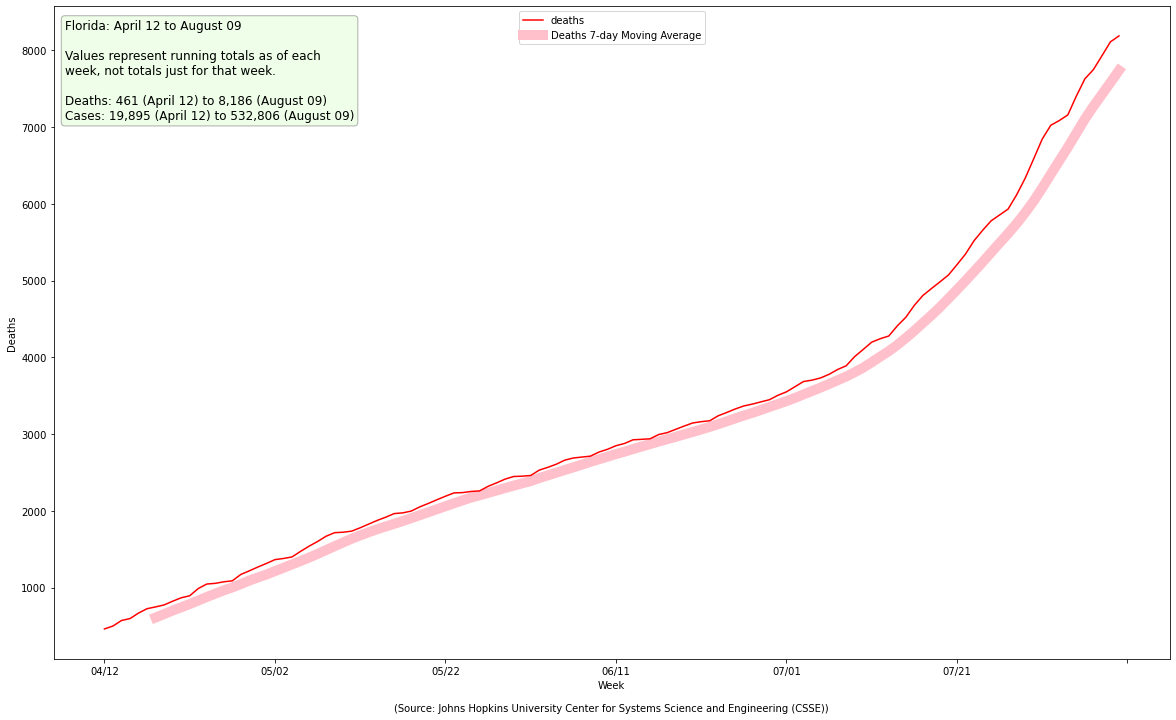

In [55]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9f820d0>)

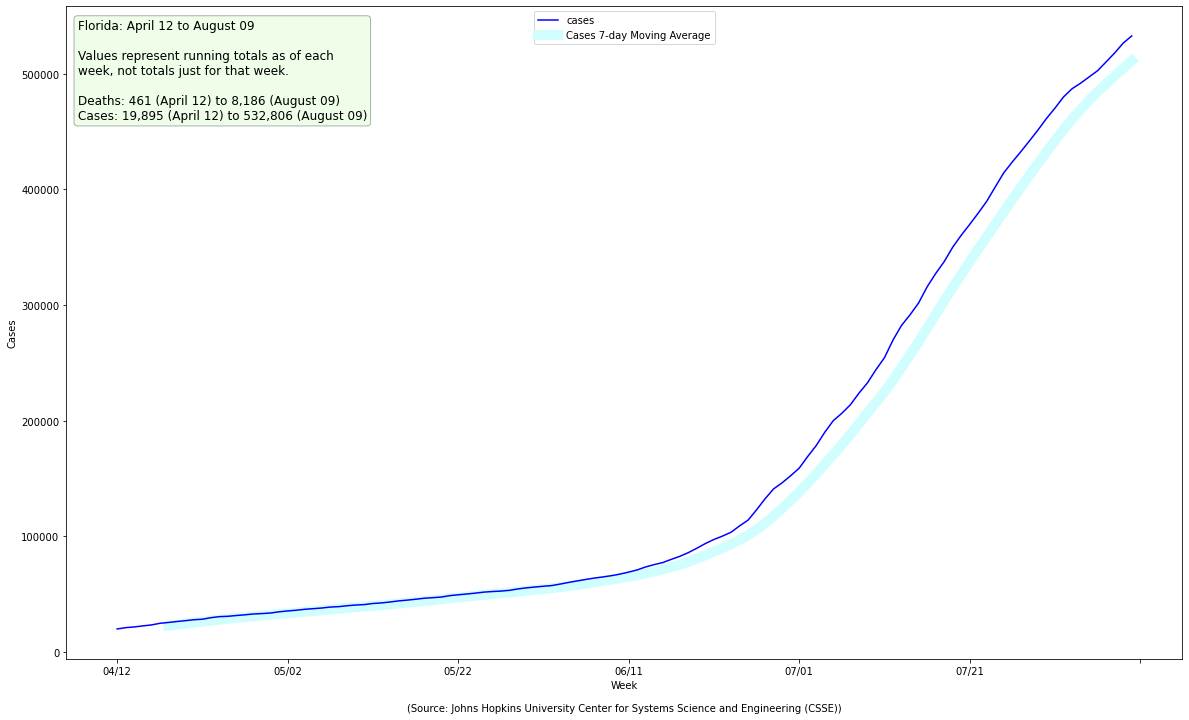

In [56]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9f7aeb0>)

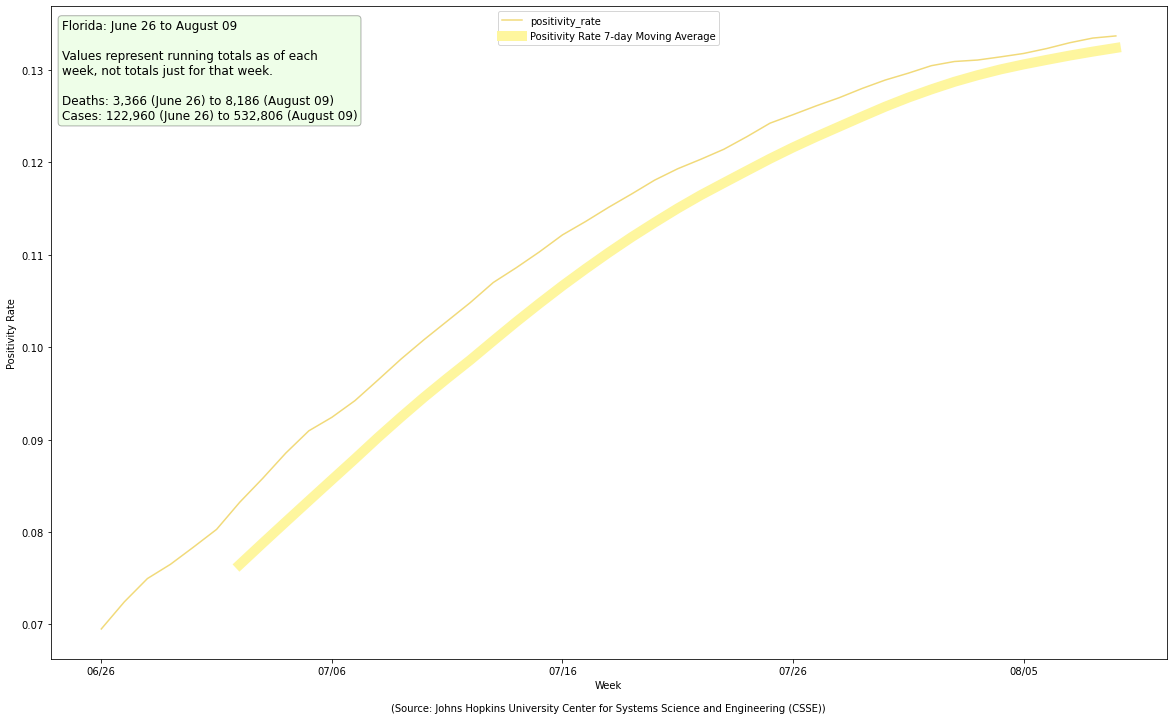

In [57]:
plot_state(df_positivity_dates, SOURCE, 'Florida', image_file='jhu-fl-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9f35850>)

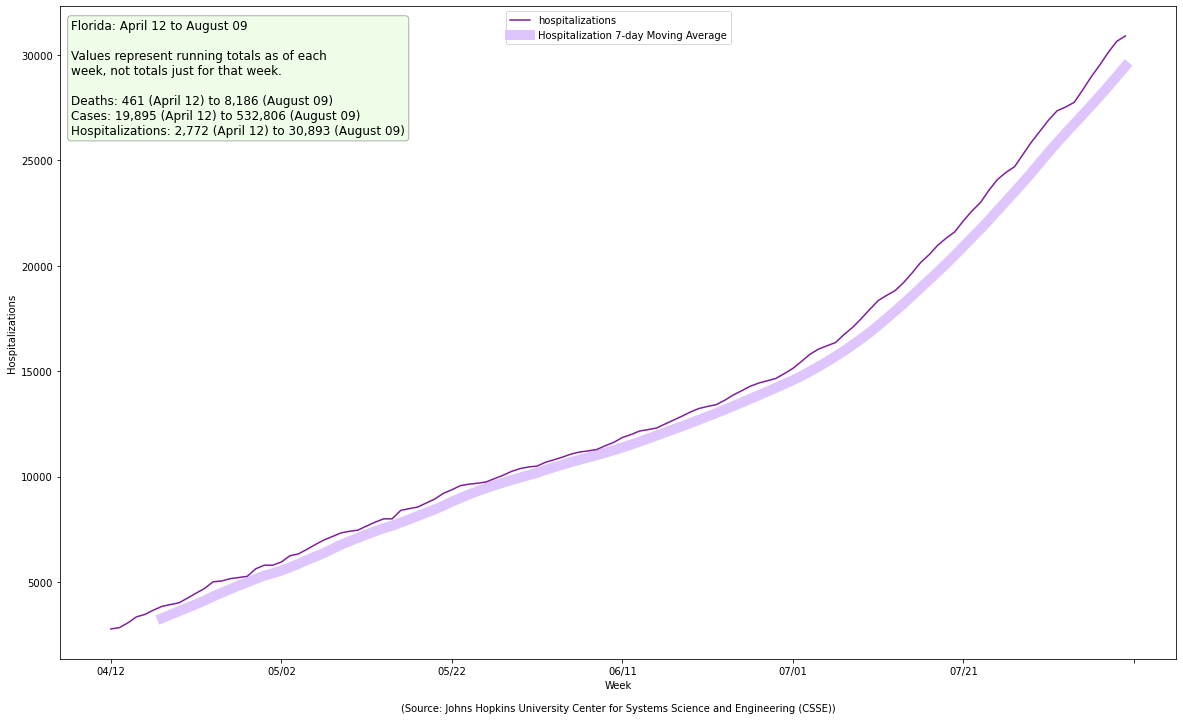

In [58]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

### South Carolina

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9e457c0>)

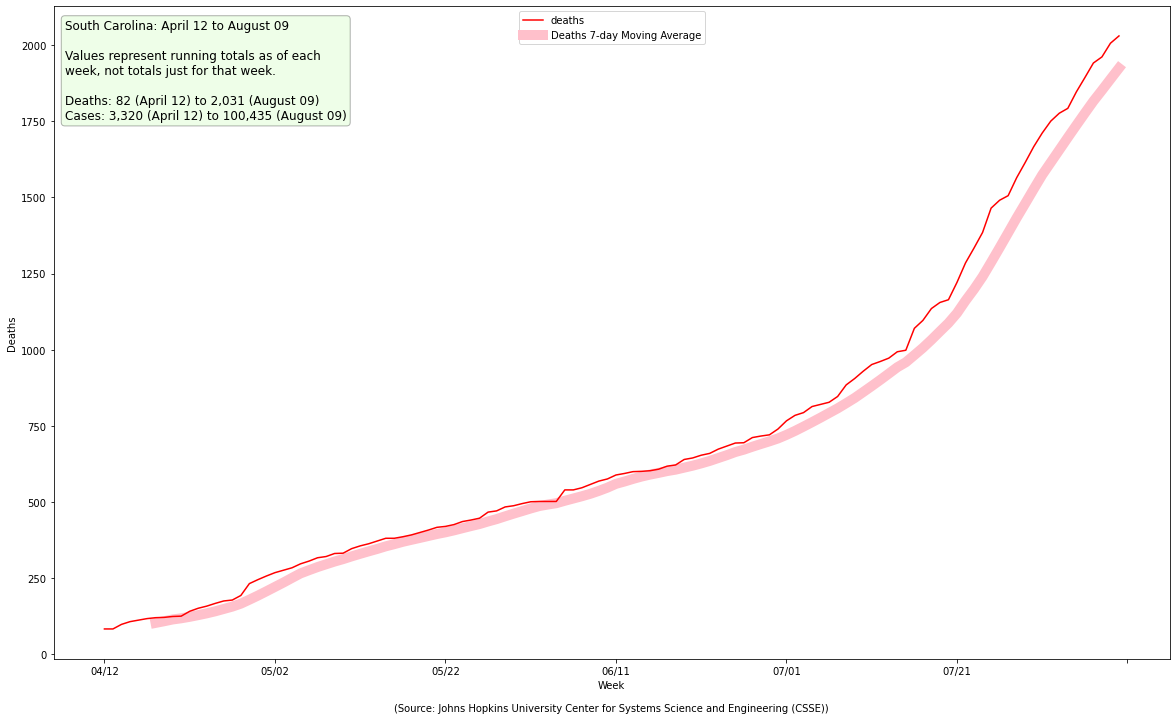

In [59]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9e348e0>)

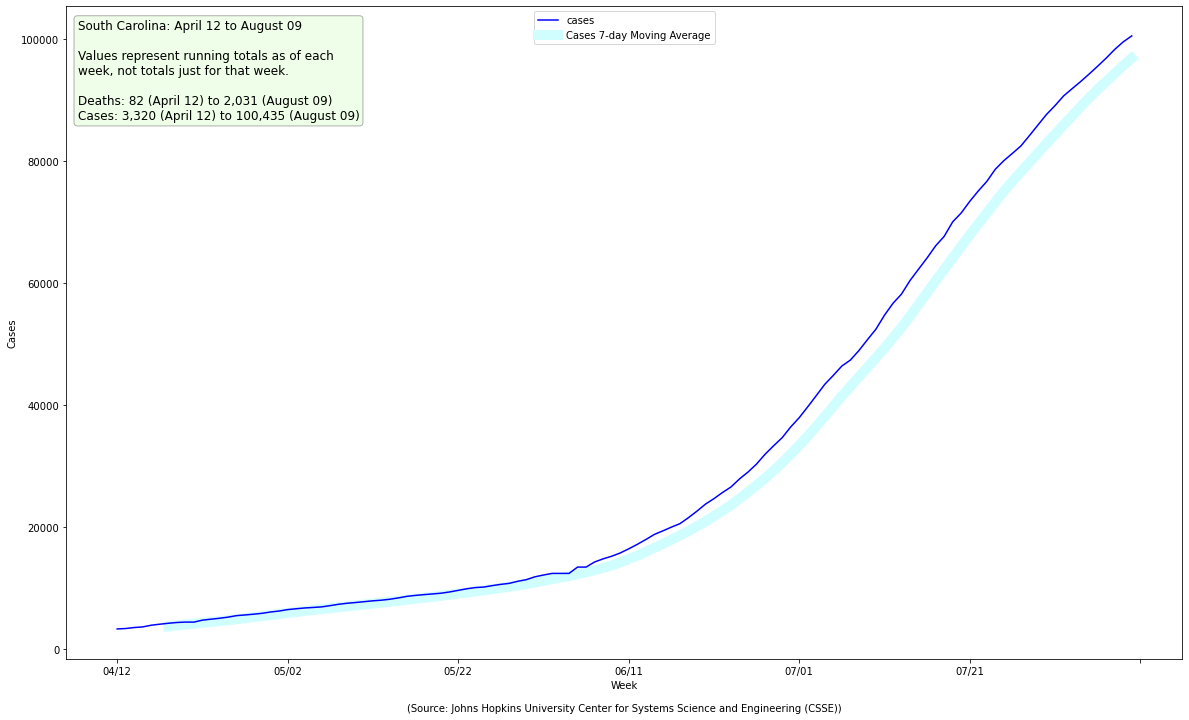

In [60]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9d9d4f0>)

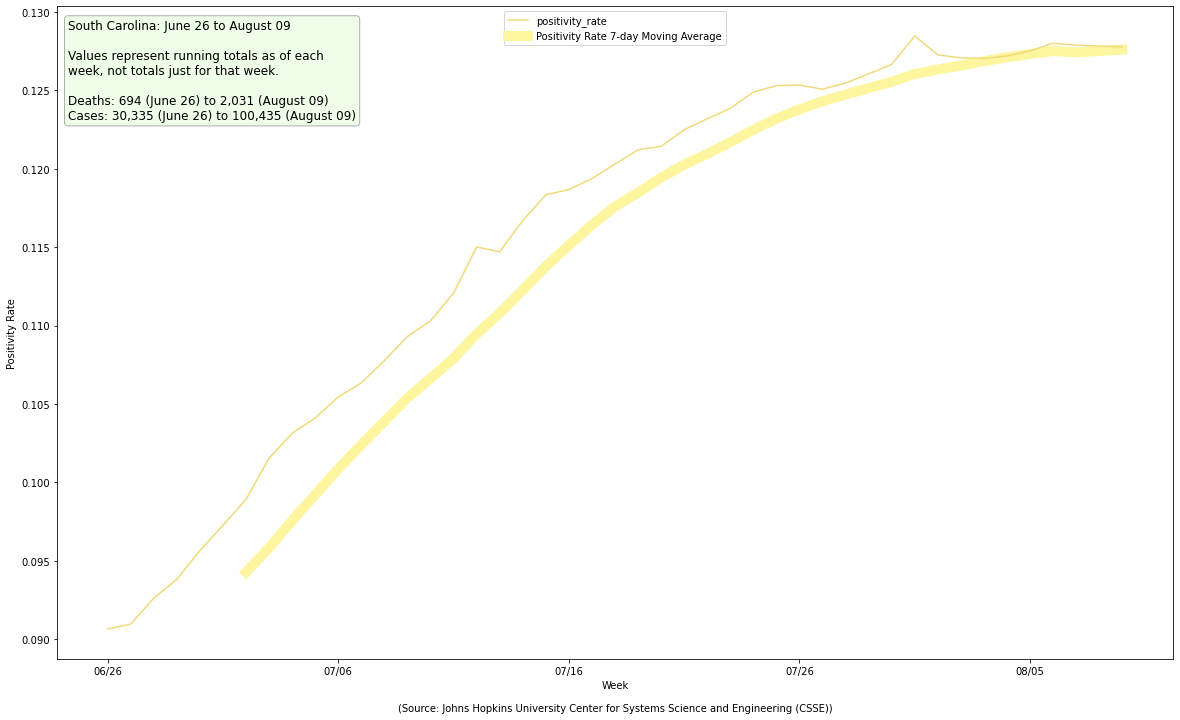

In [61]:
plot_state(df_positivity_dates, SOURCE, 'South Carolina', image_file='jhu-sc-pos.png',
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Oklahoma

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9d51be0>)

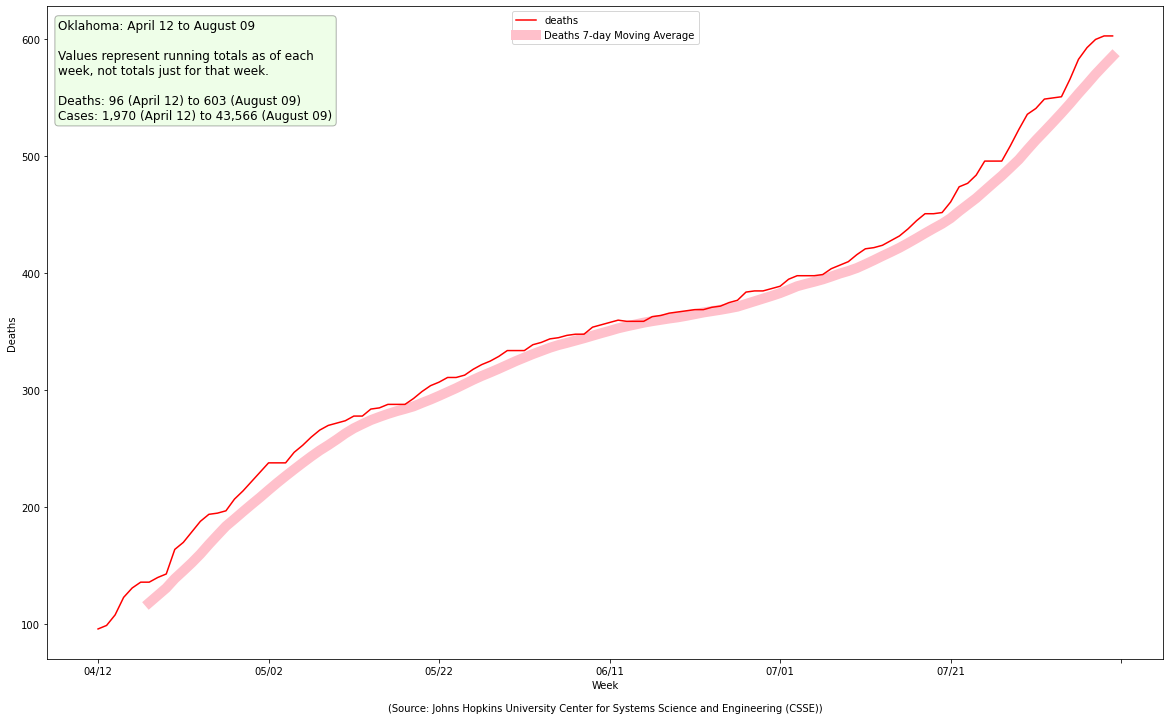

In [62]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9cf4700>)

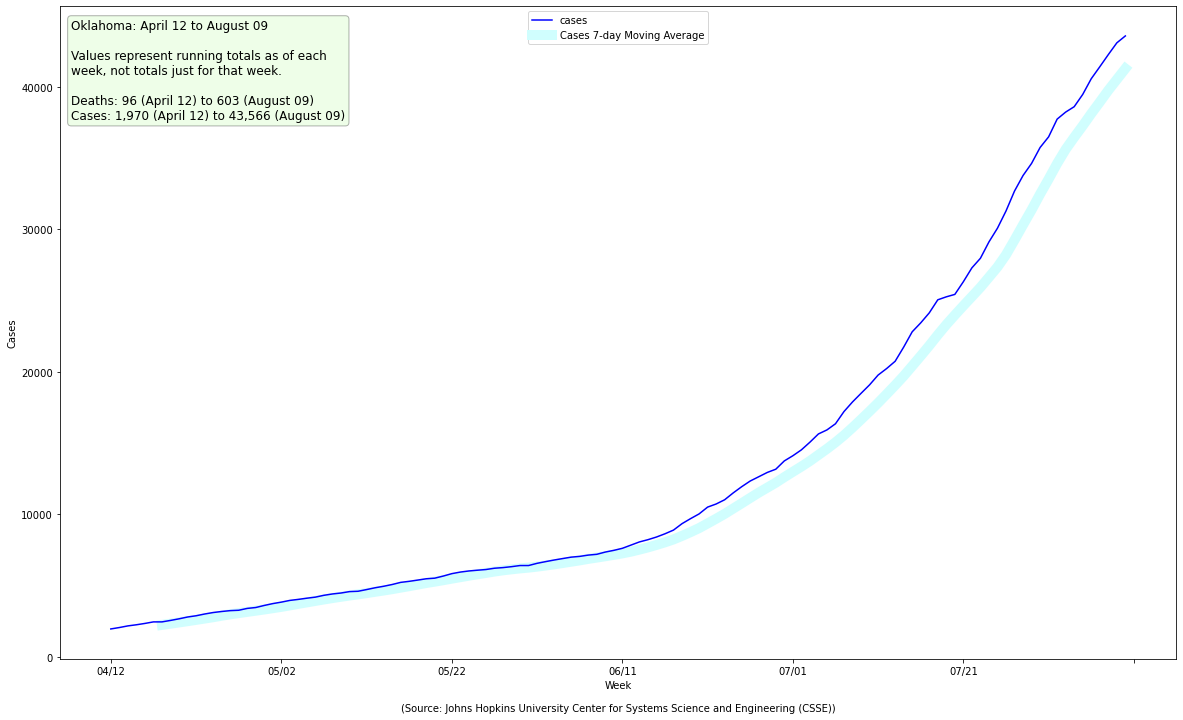

In [63]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9c55a30>)

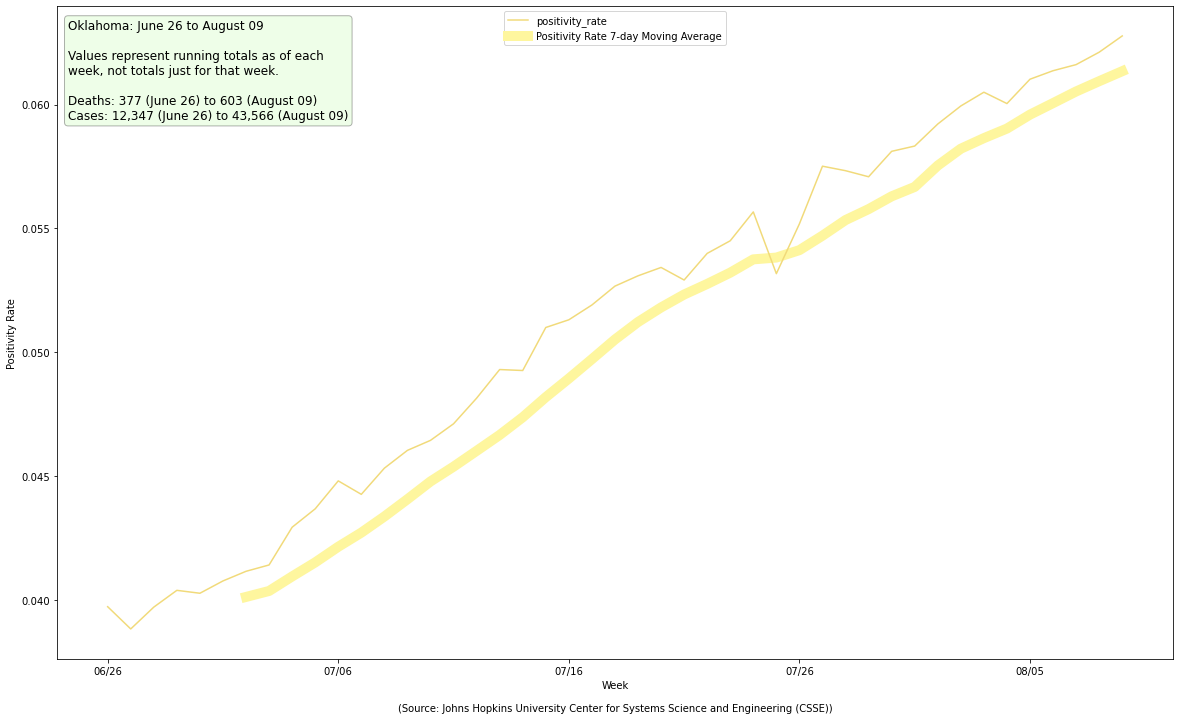

In [64]:
plot_state(df_positivity_dates, SOURCE, 'Oklahoma', image_file='jhu-ok-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9c1b730>)

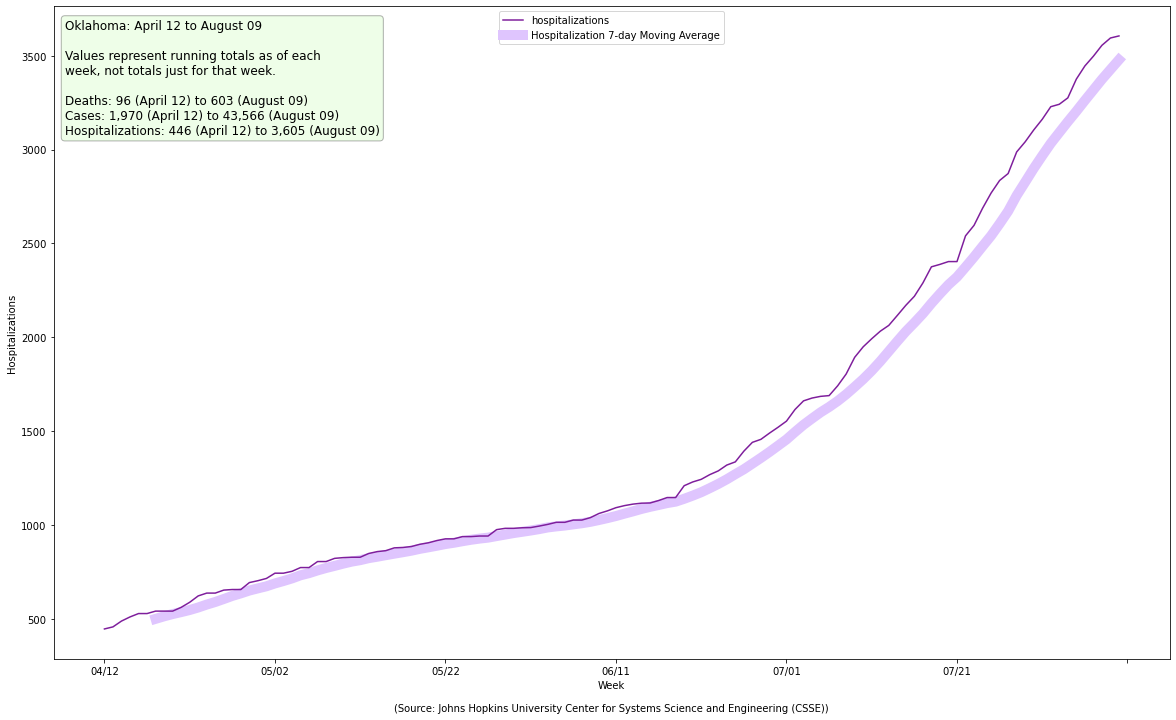

In [65]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [66]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9ba5ac0>)

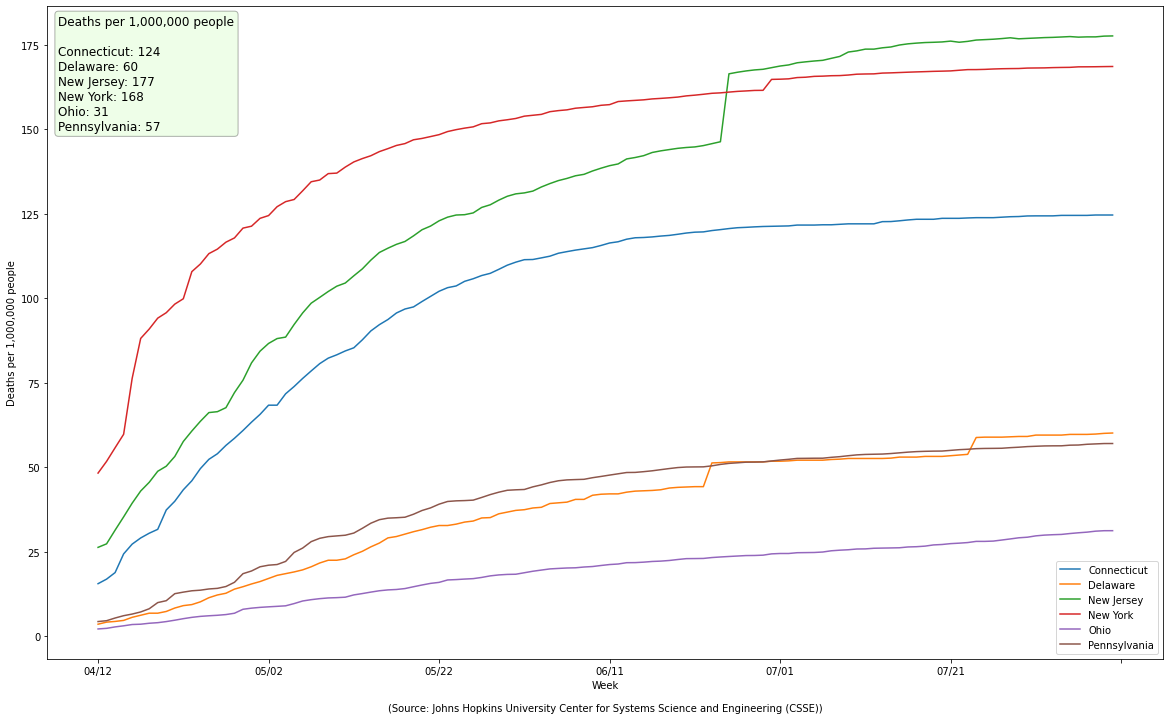

In [67]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9d5ce20>)

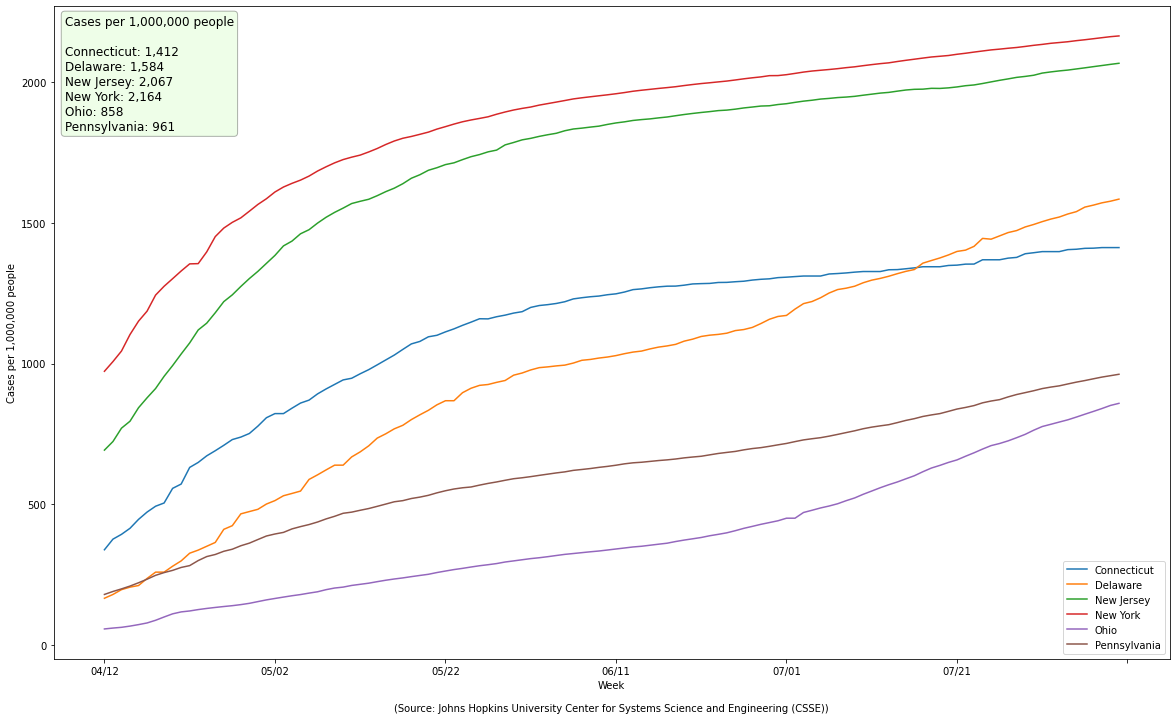

In [68]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [69]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cf01ec5e0>)

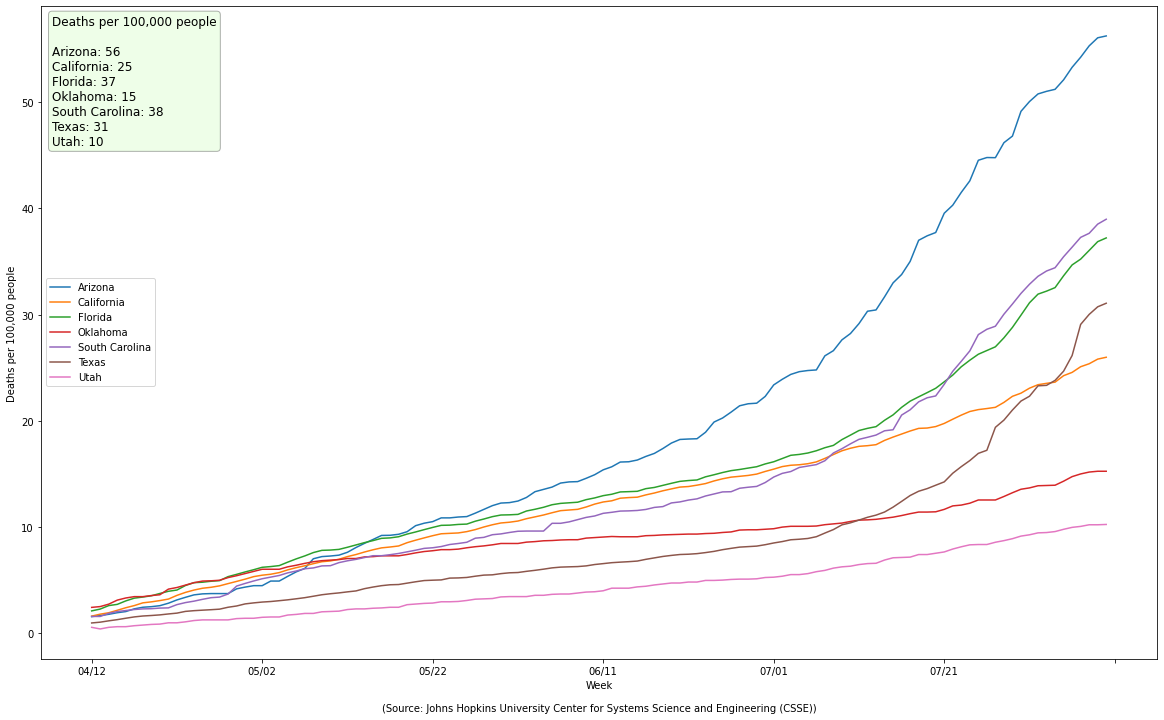

In [70]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9a63d90>)

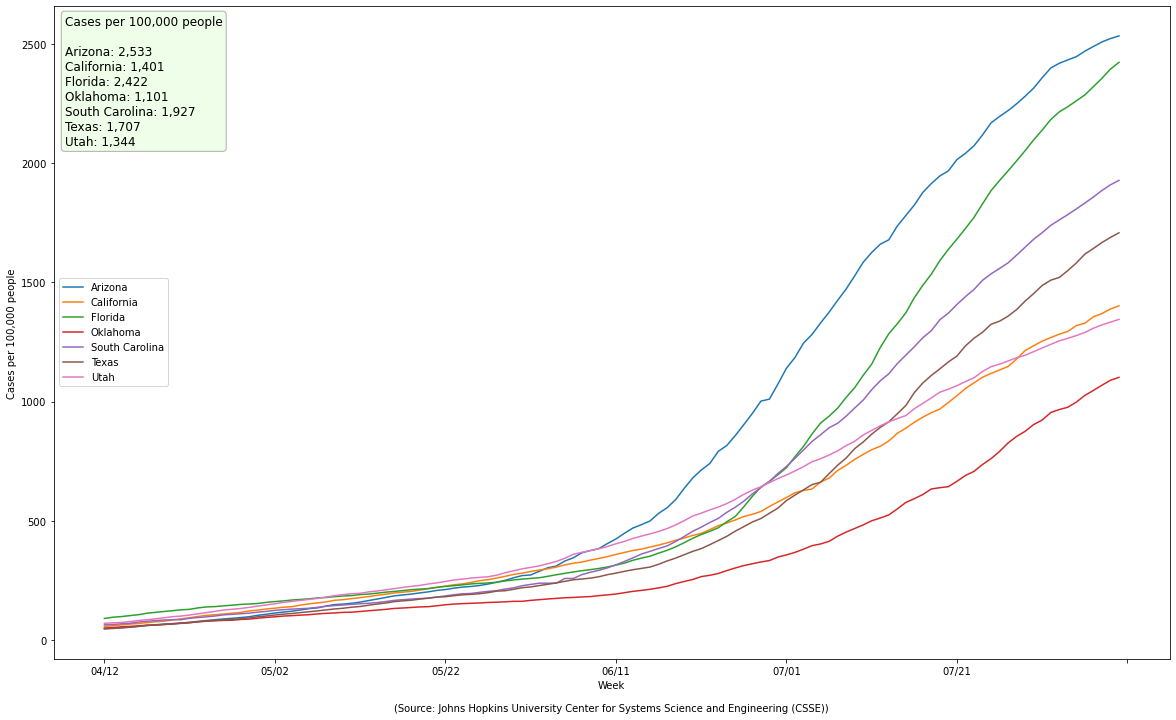

In [71]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [72]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9a63040>)

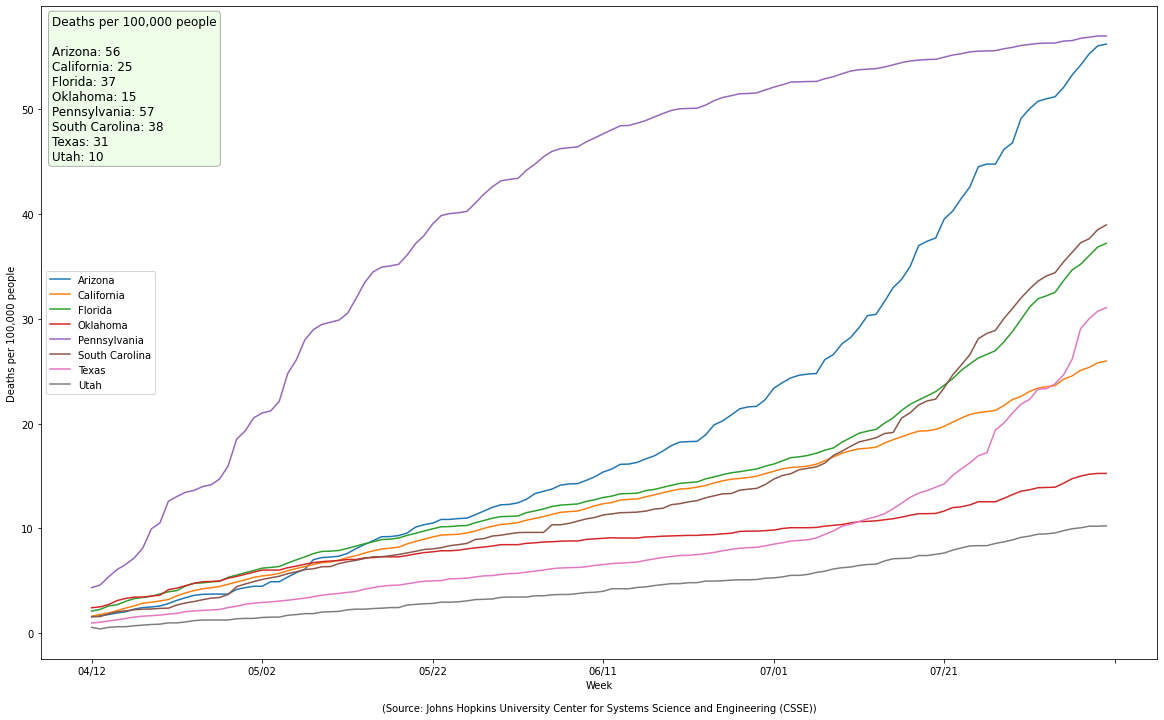

In [73]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ce9976760>)

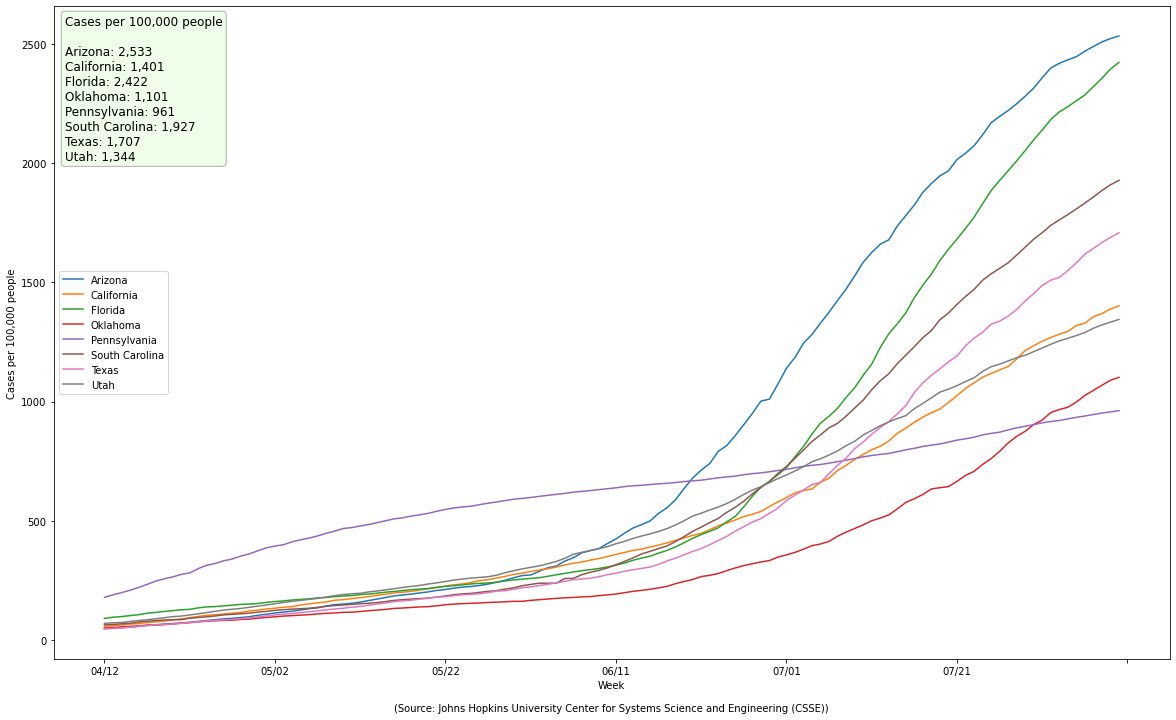

In [74]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

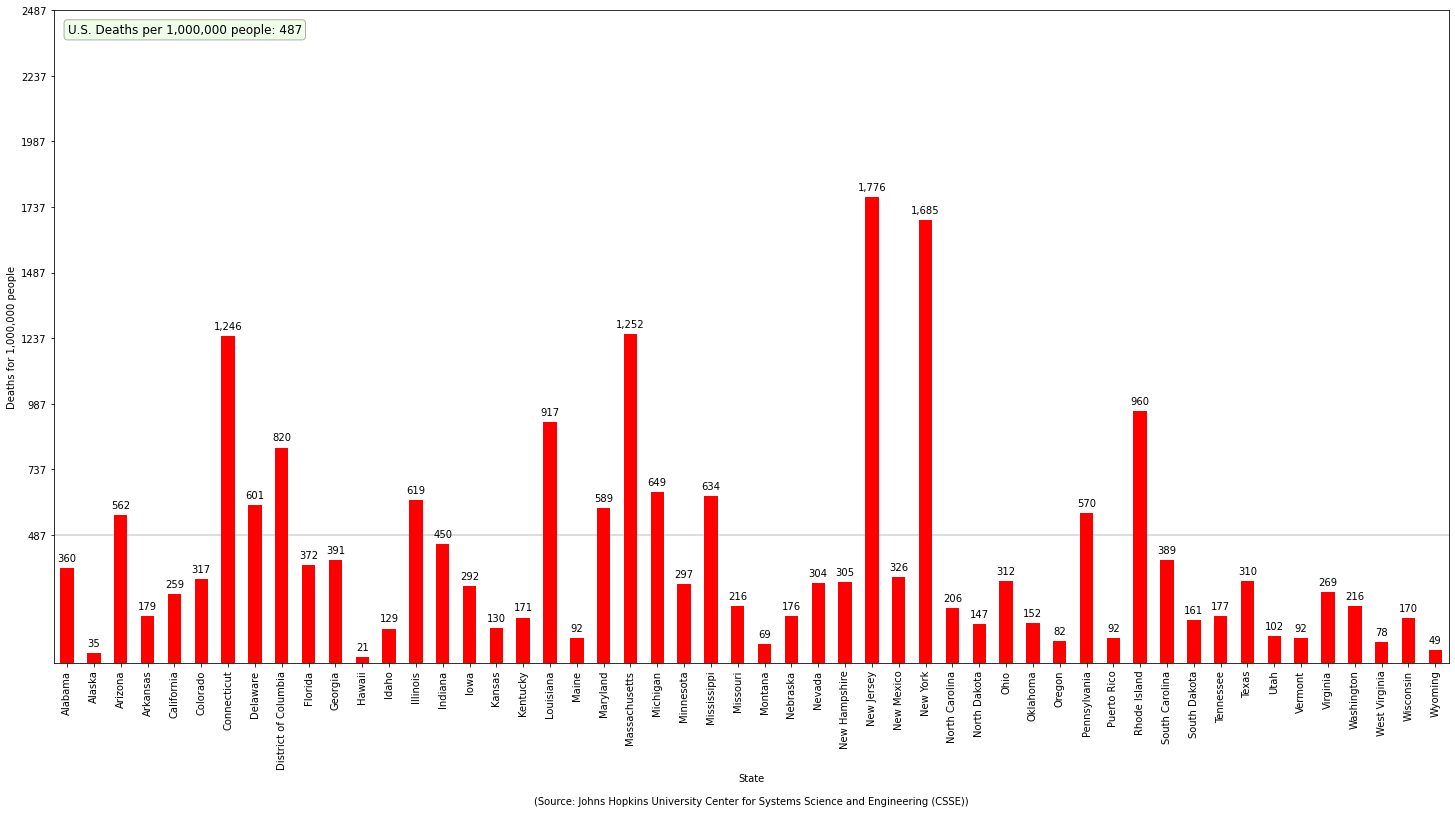

In [75]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

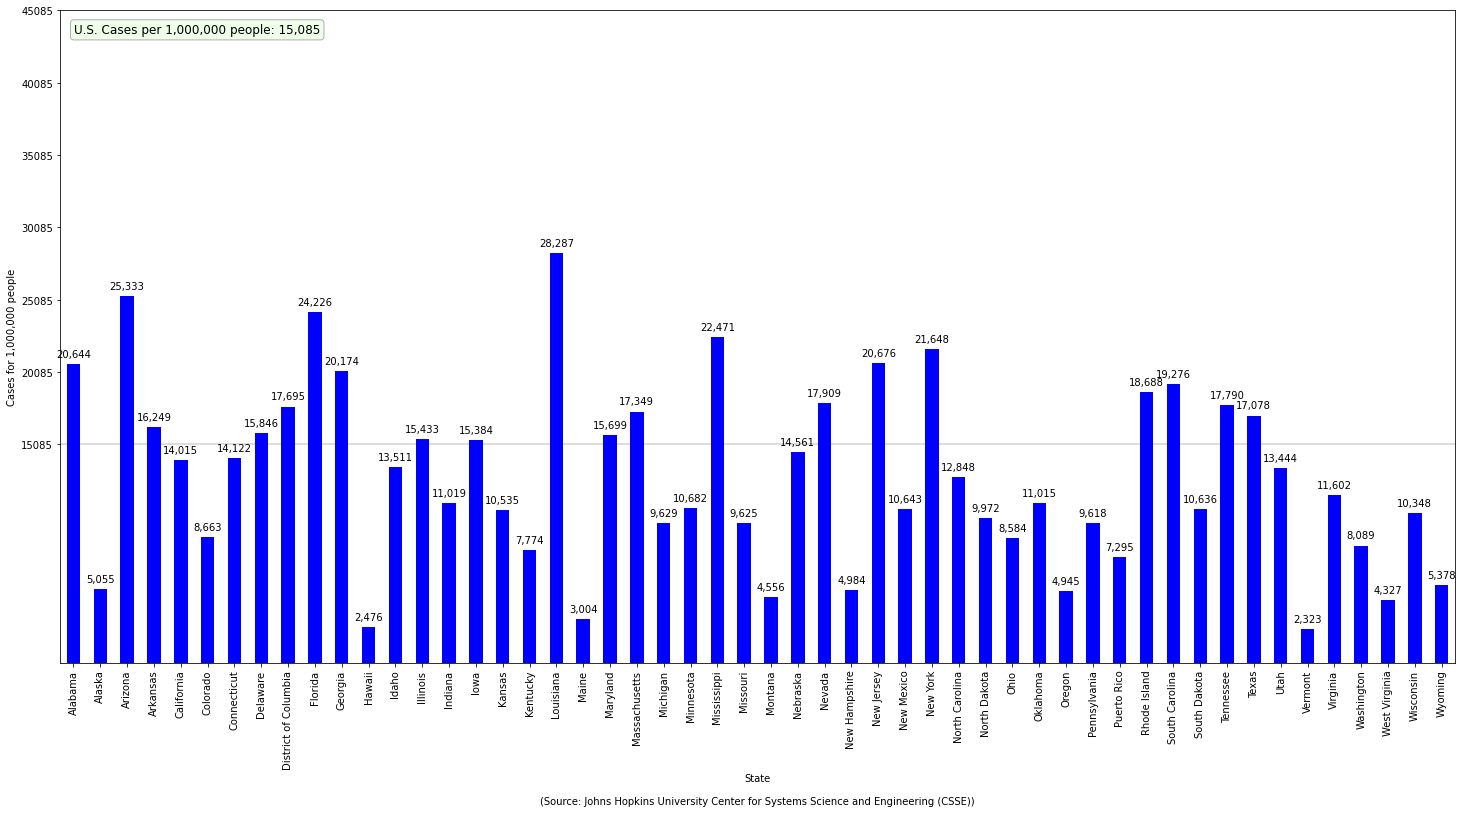

In [76]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');